# Анализ бизнес-показателей

**Цель исслеования: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет**

## <a name="contents">Задачи исследования:</a>
### Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши;
* выгрузка всех заказов за этот период;
* статистика рекламных расходов.

### Задачи исследования:

## [1. Загрузить данные и подготовить их к анализу](#stage_1)
* Загрузить данные о визитах, заказах и рекламных расходах;
* Проверить столбцы на соответствие типам.

## [2. Рассчитать метрики и построить графики](#stage_2)
**Продуктовые метрики:**
* Рассчитайте DAU, WAU и MAU. Вычислить средние значения этих метрик за весь период;
* Определить, сколько раз за день пользователи в среднем заходят на сайт;
* Исследовать, сколько времени пользователи проводят на сайте;
* Рассчитать Retention Rate, применяя когортный анализ.
 
**Метрики электронной коммерции:**
* Исследовать, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки;
* Рассчитать среднее количество покупок на одного покупателя за определённый период;
* Рассчитать средний чек;
* Проанаизировать изменение LTV на покупателя по когортам;

**Маркетинговые метрики:**
* Посчитать общую сумму расходов на маркетинг. Выяснить, как траты распределены по источникам;
* Рассчитать средний CAC на одного покупателя для всего проекта и для каждого источника трафика;
* Рассчитать ROMI по когортам в разрезе источников.

Отобразить на графиках изменения каждой метрики во времени.

## [3. Сформулировать выводы и рекомендации](#stage_3)

<a name='stage_1'><a/>
# Шаг 1. Загрузка и подготовка данных

[Вернуться к оглавлению](#contents)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mt
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
costs = pd.read_csv(r'C:\Users\Max_Berdnikov\Desktop\data\costs.csv')
orders_log = pd.read_csv(r'C:\Users\Max_Berdnikov\Desktop\data\orders_log.csv')
visits_log = pd.read_csv(r'C:\Users\Max_Berdnikov\Desktop\data\visits_log.csv')

In [3]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [4]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [5]:
costs.rename(columns={'dt': 'date'}, inplace=True)
costs['date'] = pd.to_datetime(costs['date'])

In [6]:
costs.duplicated().sum()

0

In [7]:
orders_log.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [8]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
orders_log.rename(columns={'Buy Ts': 'Buy_Ts'}, inplace=True)
orders_log['Buy_Ts'] = pd.to_datetime(orders_log['Buy_Ts'])

In [10]:
orders_log.duplicated().sum()

0

In [11]:
visits_log.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [12]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [13]:
visits_log.duplicated().sum()

0

In [14]:
visits_log.rename(columns={'End Ts': 'End_Ts', 'Start Ts': 'Start_Ts'}, inplace=True)
visits_log['End_Ts'] = pd.to_datetime(visits_log['End_Ts'])
visits_log['Start_Ts'] = pd.to_datetime(visits_log['Start_Ts'])

**Выводы**

Все необходимые столбцы приведены к типу данных datetime64. Изменены наименования некоторых столбцов. Пропусков и дублирующихся строк не обнаружено. 

<a name='stage_2'><a/>
# Шаг 2. Расчет метрик и построение графиков

[Вернуться к оглавлению](#contents)

## 2.1 Продуктовые метрики

### 2.1.1. DAU, WAU и MAU

In [15]:
visits_log['date'] = visits_log['Start_Ts'].dt.date
visits_log['day'] = visits_log['Start_Ts'].dt.day
visits_log['weekday'] = visits_log['Start_Ts'].dt.weekday
visits_log['week'] = visits_log['Start_Ts'].dt.week
visits_log['month'] = visits_log['Start_Ts'].dt.month
visits_log['year'] = visits_log['Start_Ts'].dt.year

C:\Users\Max_Berdnikov\AppData\Local\Temp\ipykernel_11856\501925957.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  visits_log['week'] = visits_log['Start_Ts'].dt.week


In [16]:
visits_log.head()

,Device,End_Ts,Source Id,Start_Ts,Uid,date,day,weekday,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,2,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,0,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,5,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,6,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,2,52,12,2017


Text(0.5, 1.0, 'DAU')

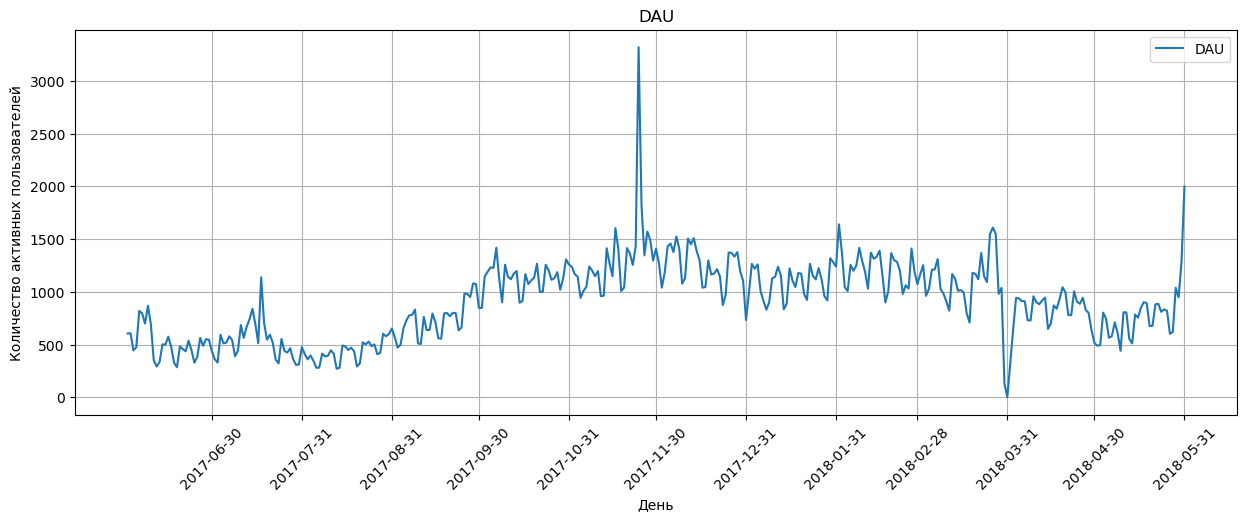

In [17]:
dau = visits_log.groupby('date').agg({'Uid': 'nunique'}).reset_index()
dau.plot(y='Uid', x='date', style='-', grid=True, figsize=(15, 5), label='DAU')
plt.xlabel('День')
plt.ylabel('Количество активных пользователей')
plt.xticks(pd.date_range(start=dau['date'].min(), end=dau['date'].max(), freq='M'), rotation=45)
plt.title('DAU')

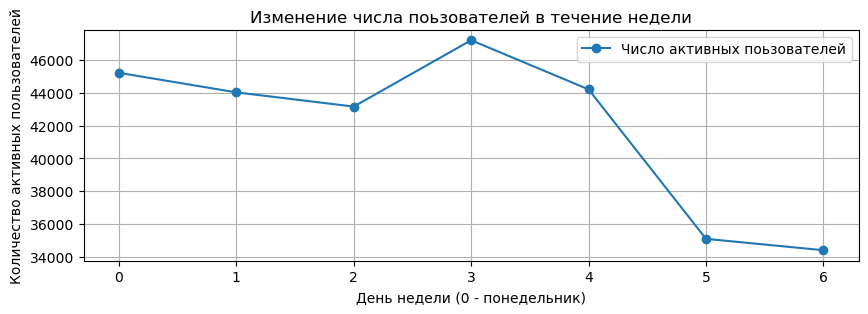

In [18]:
visits_log.groupby('weekday').agg({'Uid': 'nunique'}).plot(y='Uid', style='o-', figsize=(10,3), grid=True, label='Число активных поьзователей')
plt.xlabel('День недели (0 - понедельник)')
plt.ylabel('Количество активных пользователей')
plt.title('Изменение числа поьзователей в течение недели');

In [19]:
dau.describe()

,Uid
count,364.000000
mean,907.991758
std,370.513838
min,1.000000
25%,594.000000
50%,921.000000
75%,1173.000000
max,3319.000000


**Выводы**

Наблюдается просадка активных пользователей с недельной периодичностью. С помощью разбивки по дням недели мы выяснили, что в выходные дни количество активных юзеров сильно падает. Для более глубокого анализа необходимо изучить специфику продукта.

Также наблюдается огромный пик (увеличение более чем в 2 раза) в конце ноября. В это время как раз проходит "Черная пятница". Есть и отрицательный пик - 31 марта 2018 года, когда был зафиксирован только 1 активный пользователь. Возможно, в этот день сервис не работал или произошел технический сбой. Прослеживается тенденция постепенного увеличения числа пользователей с середины августа до середины декабря. Далее количество пользователей незначительно падает и держится на примерно одном уровне до конца марта. В апреле и мае наблюдается значительный отток юзеров. Необходимо выяснить с чем это может быть связано.

Среднее количество активных пользователей в день - **908**

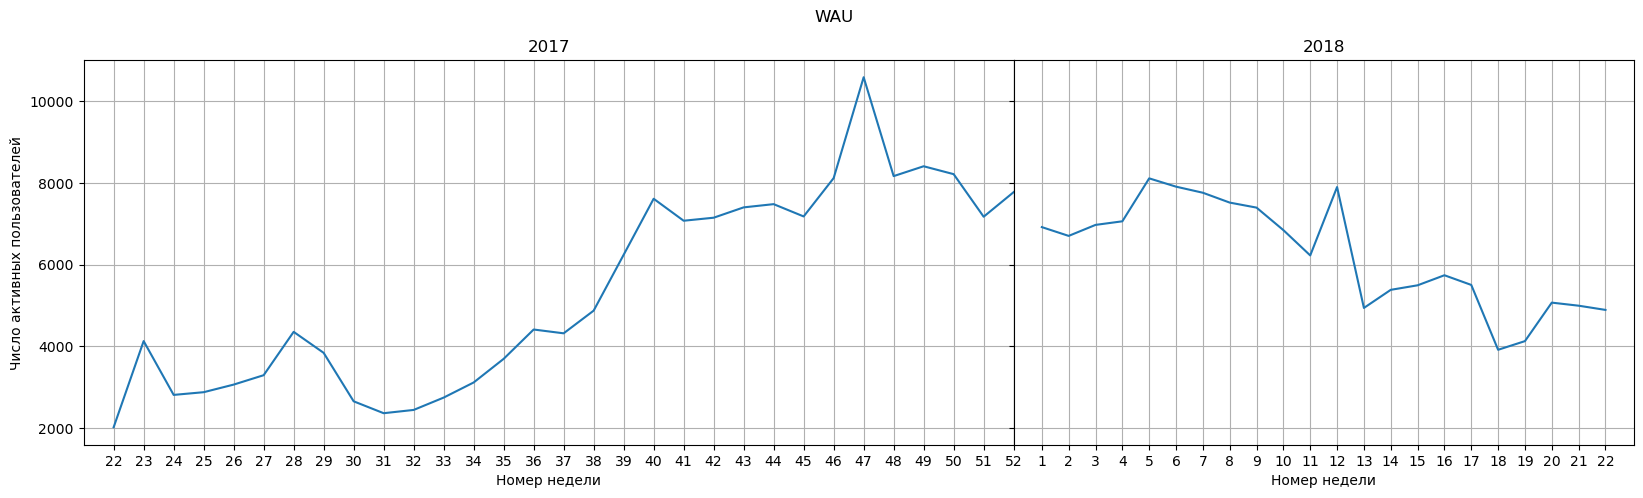

''

In [20]:
wau = visits_log.groupby(['year', 'week']).agg({'Uid': 'nunique'}).reset_index()

_, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True, width_ratios=[6, 4])
axs[0].plot(wau[wau['year']==2017]['week'], wau[wau['year']==2017]['Uid'])
axs[0].grid(True)
axs[0].set_title('2017')
axs[0].set_xlabel('Номер недели')
axs[0].set_ylabel('Число активных пользователей')
axs[0].set_xlim(21, 52)
axs[0].set_xticks(np.arange(22, 53, 1))

axs[1].plot(wau[wau['year']==2018]['week'], wau[wau['year']==2018]['Uid'])
axs[1].grid(True)
axs[1].set_title('2018')
axs[1].set_xlabel('Номер недели')
axs[1].set_xticks(np.arange(1, 23, 1))

plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('WAU')
plt.show()
;

In [21]:
wau['Uid'].describe()

count       53.000000
mean      5716.245283
std       2049.898027
min       2021.000000
25%       4128.000000
50%       5740.000000
75%       7401.000000
max      10586.000000
Name: Uid, dtype: float64

**Выводы**

На графике недельной активности наблюдаются всё те же тенденции, только в более явном виде без лишнего шума в данных.

Среднее количество активных пользователей в неделю - **5716**

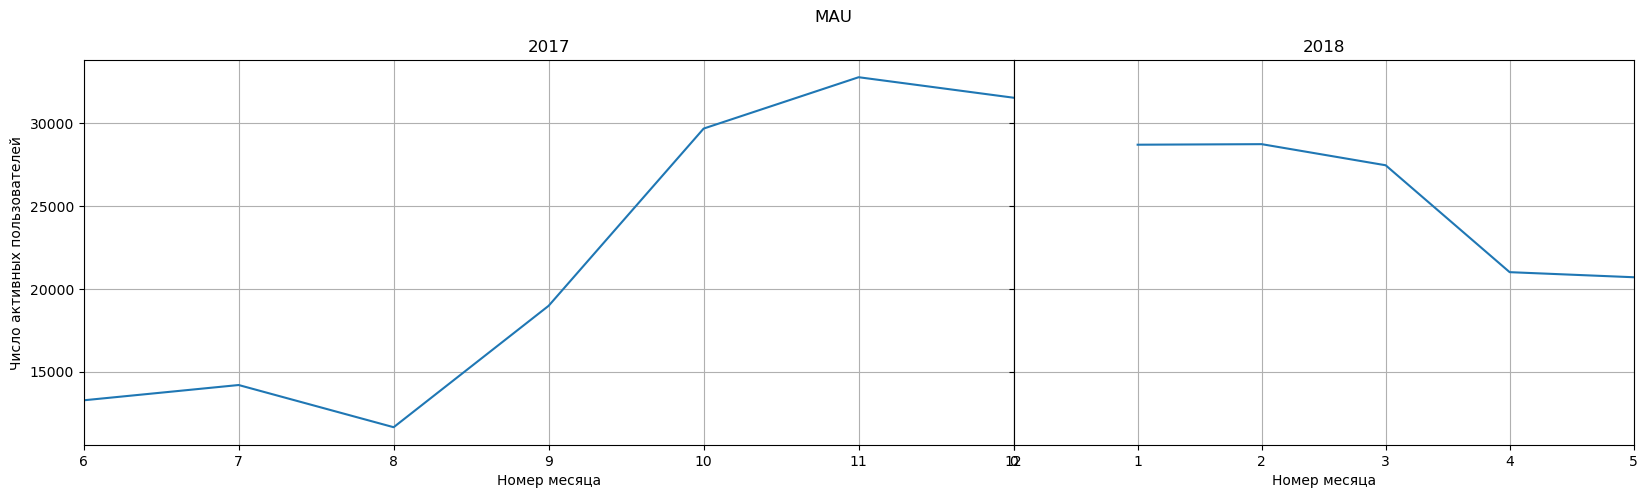

''

In [22]:
mau = visits_log.groupby(['year', 'month']).agg({'Uid': 'nunique'}).reset_index()

_, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True, width_ratios=[6, 4])
axs[0].plot(mau[mau['year']==2017]['month'], mau[mau['year']==2017]['Uid'])
axs[0].grid(True)
axs[0].set_title('2017')
axs[0].set_xlabel('Номер месяца')
axs[0].set_ylabel('Число активных пользователей')
axs[0].set_xlim(6, 12)
#axs[0].set_xticks(np.arange(22, 53, 1));

axs[1].plot(mau[mau['year']==2018]['month'], mau[mau['year']==2018]['Uid'])
axs[1].grid(True)
axs[1].set_title('2018')
axs[1].set_xlabel('Номер месяца')
axs[1].set_xlim(0, 5)
#axs[1].set_xticks(np.arange(1, 23, 1))

plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('MAU')
plt.show()
;

In [23]:
mau['Uid'].describe()

count       12.000000
mean     23228.416667
std       7546.380462
min      11631.000000
25%      17777.000000
50%      24240.500000
75%      28984.750000
max      32797.000000
Name: Uid, dtype: float64

**Вывод**

Если это не молодая компания, то подобное изменение количества активных пользователей можно объяснить сезонностью продукта: видно, что с начала марта количество пользователей начинает постепенно снижаться, а за апрель и вовсе теряется до 5000 пользователей. Практически линейный график бурного роста начинается с августа и достигает апогея в конце ноября.

Среднее количество активных пользователей в месяц - **23228**

### 2.1.2. Сколько раз за день пользователи в среднем заходят на сайт

Text(0.5, 1.0, 'Количество посещений сайта')

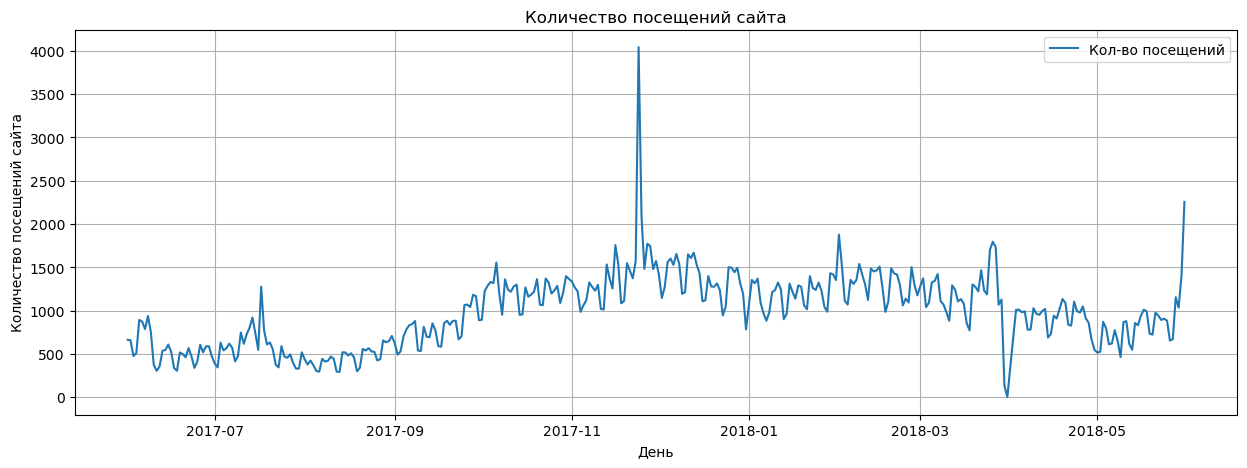

In [24]:
visits_count = visits_log.groupby('date').agg({'Uid': 'count'}).reset_index()
visits_count.plot(y='Uid', x='date', style='-', grid=True, figsize=(15, 5), label='Кол-во посещений')
plt.xlabel('День')
plt.ylabel('Количество посещений сайта')
plt.title('Количество посещений сайта')

In [25]:
visits_dau = visits_count.merge(dau, on='date')
visits_dau.columns = ['date', 'visits', 'dau']
visits_dau

,date,visits,dau
0,2017-06-01,664,605
1,2017-06-02,658,608
2,2017-06-03,477,445
3,2017-06-04,510,476
4,2017-06-05,893,820
...,...,...,...
359,2018-05-27,672,620
360,2018-05-28,1156,1039
361,2018-05-29,1035,948
362,2018-05-30,1410,1289


In [26]:
visits_dau['dau'].sum() / visits_dau['visits'].sum()

0.919613244296049

In [27]:
visits_count.merge(dau, on='date').corr()

C:\Users\Max_Berdnikov\AppData\Local\Temp\ipykernel_11856\3492765475.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  visits_count.merge(dau, on='date').corr()


,Uid_x,Uid_y
Uid_x,1.000000,0.998191
Uid_y,0.998191,1.000000


In [28]:
visits_count.mean()

C:\Users\Max_Berdnikov\AppData\Local\Temp\ipykernel_11856\3844155959.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  visits_count.mean()


Uid    987.362637
dtype: float64

**Вывод**

И по графику, и по коэффициенту Пирсона видна очень высокая корреляция числа посещений с числом активных юзеров. Это объясняется тем, что пользователям достаточно одного посещения в сутки. Ориентируясь на табличные данные, можно сказать, что 92% пользователей заходят на сайт только 1 раз за день.

В среднем за день на сайт заходят **987** поьзователей

### 2.1.3. Время, проведенное на сайте

In [29]:
visits_log['session_duration'] = round((visits_log['End_Ts'] - visits_log['Start_Ts']).dt.seconds / 60, 2)

In [30]:
visits_log['session_duration'].describe()

count    359400.000000
mean         10.725116
std          16.938908
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max        1408.000000
Name: session_duration, dtype: float64

In [31]:
len(visits_log[visits_log['session_duration'] == 0]) / visits_log.shape[0]

0.0995937673900946

**Около 10% сессий с нулевой продолжительностью. Для данного исследования их стоит отсечь**

(0.0, 100.0)

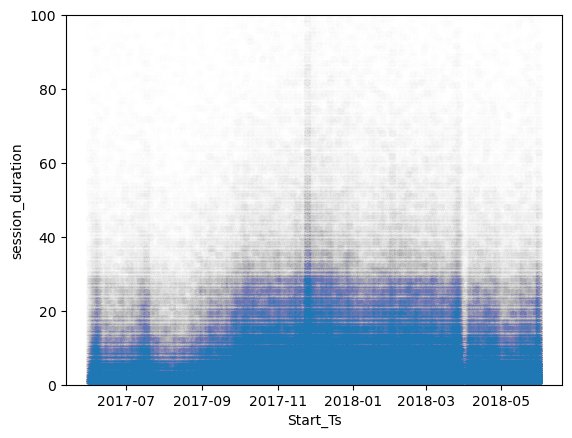

In [32]:
visits_log[~(visits_log['session_duration'] == 0)].plot(x='Start_Ts', y='session_duration', kind='scatter', alpha=0.002)
plt.ylim(0, 100)

<Axes: ylabel='Frequency'>

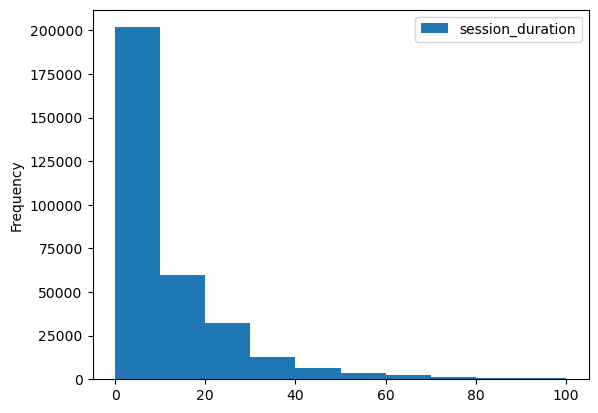

In [33]:
visits_log[~(visits_log['session_duration'] == 0)].plot(y='session_duration', kind='hist', range=(0, 100))

In [34]:
visits_log[~(visits_log['session_duration'] == 0)]['session_duration'].describe()

count    323606.000000
mean         11.911419
std          17.450874
min           0.320000
25%           2.000000
50%           6.000000
75%          15.000000
max        1408.000000
Name: session_duration, dtype: float64

**Выводы** 

В среднем пользователи проводят на сайте около 12 минут

### 2.1.4. Retention Rate

In [35]:
pd.set_option('display.max_columns', None)

In [36]:
visits_log.head()

,Device,End_Ts,Source Id,Start_Ts,Uid,date,day,weekday,week,month,year,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,2,51,12,2017,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,0,8,2,2018,28.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,5,26,7,2017,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,6,20,5,2018,24.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,2,52,12,2017,0.0


In [37]:
first_visit = visits_log.groupby('Uid').agg({'Start_Ts': 'min'}).reset_index()
first_visit.columns = ['Uid', 'first_visit']
first_visit['first_visit_date'] = first_visit['first_visit'].dt.date
first_visit.head()

,Uid,first_visit,first_visit_date
0,11863502262781,2018-03-01 17:27:00,2018-03-01
1,49537067089222,2018-02-06 15:55:00,2018-02-06
2,297729379853735,2017-06-07 18:47:00,2017-06-07
3,313578113262317,2017-09-18 22:49:00,2017-09-18
4,325320750514679,2017-09-30 14:29:00,2017-09-30


In [38]:
visits_log = visits_log.merge(first_visit, on='Uid', how='left')

In [39]:
visits_log['visit_month'] = visits_log['date'].astype('datetime64[M]')
visits_log['first_visit_month'] = visits_log['first_visit_date'].astype('datetime64[M]')
visits_log.head()

,Device,End_Ts,Source Id,Start_Ts,Uid,date,day,weekday,week,month,year,session_duration,first_visit,first_visit_date,visit_month,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,2,51,12,2017,18.0,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,0,8,2,2018,28.0,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,5,26,7,2017,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,6,20,5,2018,24.0,2018-03-09 20:05:00,2018-03-09,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,2,52,12,2017,0.0,2017-12-27 14:06:00,2017-12-27,2017-12-01,2017-12-01


In [40]:
visits_log['cohort_lifetime'] = visits_log['visit_month'] - visits_log['first_visit_month']
visits_log['cohort_lifetime'] = (visits_log['cohort_lifetime'] / np.timedelta64(1, 'M'))
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].round().astype('int')

In [41]:
visits_log.head()

,Device,End_Ts,Source Id,Start_Ts,Uid,date,day,weekday,week,month,year,session_duration,first_visit,first_visit_date,visit_month,first_visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,2,51,12,2017,18.0,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,0,8,2,2018,28.0,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,5,26,7,2017,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,6,20,5,2018,24.0,2018-03-09 20:05:00,2018-03-09,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,2,52,12,2017,0.0,2017-12-27 14:06:00,2017-12-27,2017-12-01,2017-12-01,0


In [42]:
cohorts = visits_log.groupby(['first_visit_month', 'cohort_lifetime']).agg({'Uid': 'nunique'}).reset_index()
cohorts

,first_visit_month,cohort_lifetime,Uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [43]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'Uid']]
initial_users_count.rename(columns={'Uid': 'cohort_users'}, inplace=True)
initial_users_count

,first_visit_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [44]:
cohorts = cohorts.merge(initial_users_count, on='first_visit_month', how='left')

In [45]:
cohorts['retention'] = round(cohorts['Uid'] / cohorts['cohort_users'], 4)
cohorts

,first_visit_month,cohort_lifetime,Uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.0000
1,2017-06-01,1,1043,13259,0.0787
2,2017-06-01,2,713,13259,0.0538
3,2017-06-01,3,814,13259,0.0614
4,2017-06-01,4,909,13259,0.0686
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.0418
74,2018-03-01,2,557,20589,0.0271
75,2018-04-01,0,15709,15709,1.0000
76,2018-04-01,1,760,15709,0.0484


In [46]:
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.0787,0.0538,0.0614,0.0686,0.0714,0.0610,0.0578,0.0523,0.0508,0.0407,0.045
2017-07-01,1.0,0.0561,0.0513,0.0562,0.0582,0.0482,0.0454,0.0457,0.0388,0.0286,0.0275,NaN
2017-08-01,1.0,0.0769,0.0629,0.0628,0.0501,0.0440,0.0363,0.0395,0.0279,0.0260,NaN,NaN
2017-09-01,1.0,0.0855,0.0692,0.0507,0.0394,0.0378,0.0359,0.0242,0.0228,NaN,NaN,NaN
2017-10-01,1.0,0.0786,0.0522,0.0390,0.0343,0.0322,0.0214,0.0204,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.0783,0.0441,0.0387,0.0337,0.0234,0.0218,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.0558,0.0380,0.0311,0.0203,0.0190,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.0597,0.0393,0.0250,0.0202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.0571,0.0255,0.0201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
retention_pivot.mean() * 100

cohort_lifetime
0     100.000000
1       6.517273
2       4.634000
3       4.277778
4       4.060000
5       3.942857
6       3.696667
7       3.752000
8       3.545000
9       3.513333
10      3.410000
11      4.500000
dtype: float64

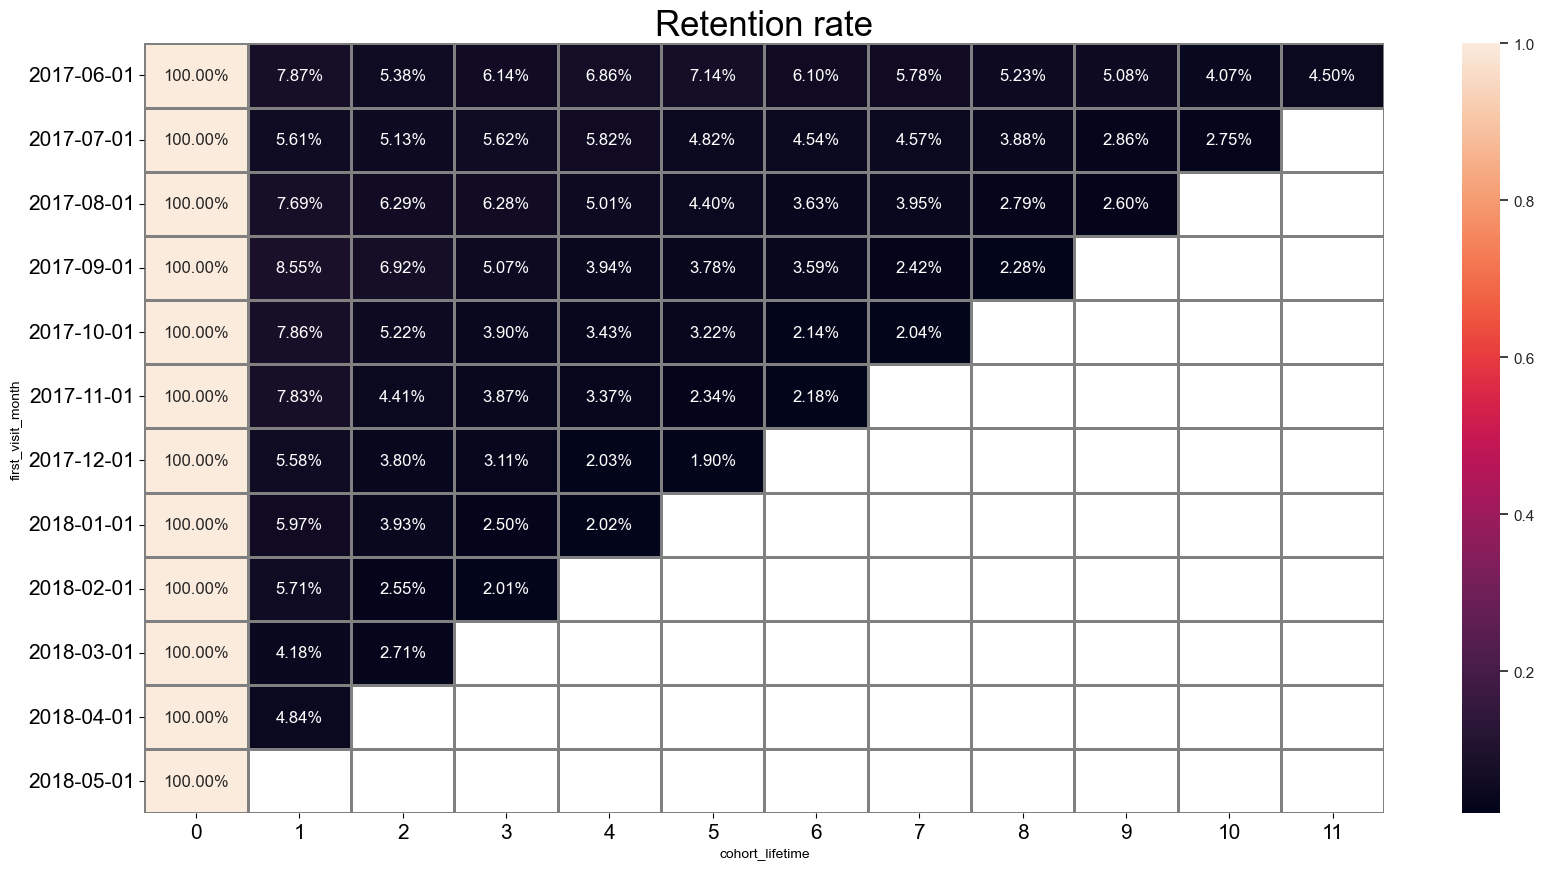

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(style='white')
sns.set(font_scale=1)
plt.tick_params(axis='both', which='major', labelsize= 15)
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray')
plt.title('Retention rate', fontsize=25)
ax.set_yticklabels(retention_pivot.index.date)
plt.show()

**Выводы**

* Видно, что после первого месяца пользования уходят около 94% пользователей. Это говорит о том, что специфика бизнеса рассчитана в основном на единоразовую сделку.
* Несмотря на это, для последующих месяцев в каждой когорте остается стабильный процент постоянных пользователей (порядка 3-4%)

## 2.2. Метрики электронной коммерции

### 2.2.1. Время с момента первого посещения сайта до совершения покупки

In [49]:
orders_log.head()

,Buy_Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [50]:
visits_log.head()

,Device,End_Ts,Source Id,Start_Ts,Uid,date,day,weekday,week,month,year,session_duration,first_visit,first_visit_date,visit_month,first_visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,2,51,12,2017,18.0,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,0,8,2,2018,28.0,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,5,26,7,2017,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,6,20,5,2018,24.0,2018-03-09 20:05:00,2018-03-09,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,2,52,12,2017,0.0,2017-12-27 14:06:00,2017-12-27,2017-12-01,2017-12-01,0


In [51]:
first_order = orders_log.groupby('Uid').agg({'Buy_Ts':'min'})\
                .rename(columns={'Buy_Ts':'first_purchase_date'})\
                .reset_index()
first_visit = visits_log.groupby('Uid').agg({'Start_Ts':'min'})\
                .rename(columns={'Start_Ts':'first_visit_date'})\
                .reset_index()
buy = first_visit.merge(first_order, on='Uid', how='inner')

In [52]:
buy['buying_time_minute'] = (buy['first_purchase_date'] - buy['first_visit_date']).dt.total_seconds() / 60

In [53]:
buy.head()

,Uid,first_visit_date,first_purchase_date,buying_time_minute
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


In [54]:
buy['buying_time_minute'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: buying_time_minute, dtype: float64

In [55]:
# Посчитаем долю пользователей, где времени между первым заходом и покупкой нет
len(buy[buy['buying_time_minute'] == 0]) / buy.shape[0]

0.06721791747665855

<Axes: >

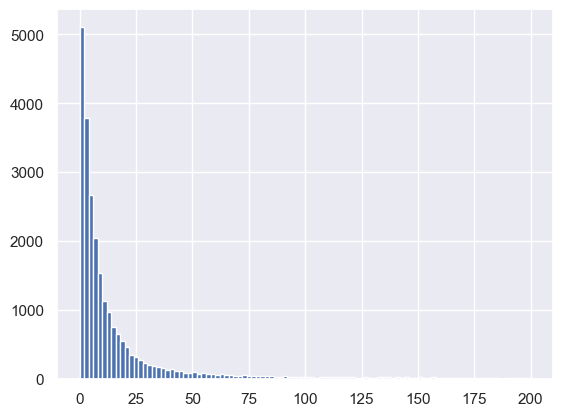

In [56]:
buy['buying_time_minute'].hist(bins=100, range=(0, 200))

**Вывод**

Среднее время между первым посещением сайта и первой покупкой составляет **16 минут**.

Ориентироваться на среднее значение в данном случае некорректно, т.к. распределение имеет очень длинный левый хвост (пользователи, у которых между посещением и покупкой прошел почти год) и имеет сильное влияние на среднее значение. Поэтому используем медиану, которая устойчива к выбросам.

### 2.2.2. Среднее количество покупок на одного покупателя за определённый период

In [57]:
orders_log['purchase_date'] = orders_log['Buy_Ts'].dt.date
orders_log = orders_log.merge(first_order, on='Uid', how='left')

In [58]:
orders_log['first_purchase_date'] = orders_log['first_purchase_date'].dt.date
orders_log['order_month'] = orders_log['purchase_date'].astype('datetime64[M]')
orders_log['first_order_month'] = orders_log['first_purchase_date'].astype('datetime64[M]')

In [59]:
orders_log.head()

,Buy_Ts,Revenue,Uid,purchase_date,first_purchase_date,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [61]:
purchase_per_user = orders_log.groupby('order_month').agg({'Uid': ['nunique', 'count']}).reset_index()
purchase_per_user.columns = ['order_month', 'count_users', 'count_purchases']
purchase_per_user['purchase_per_user'] = round(purchase_per_user['count_purchases'] / purchase_per_user['count_users'], 2)
purchase_per_user

,order_month,count_users,count_purchases,purchase_per_user
0,2017-06-01,2023,2354,1.16
1,2017-07-01,1984,2363,1.19
2,2017-08-01,1472,1807,1.23
3,2017-09-01,2750,3387,1.23
4,2017-10-01,4675,5679,1.21
5,2017-11-01,4547,5659,1.24
6,2017-12-01,4942,6218,1.26
7,2018-01-01,3898,4721,1.21
8,2018-02-01,4258,5281,1.24
9,2018-03-01,4181,5326,1.27


In [108]:
# Рассмотрим среднее значение за всё время: возбмем все заказы и поделим на количество уникальных пользователей
round(purchase_per_user['count_purchases'].sum() / purchase_per_user['count_users'].sum(), 2)

1.23

Text(0.5, 1.0, 'Изменение метрики "Среднее кол-во покупок на 1-го пользователя"')

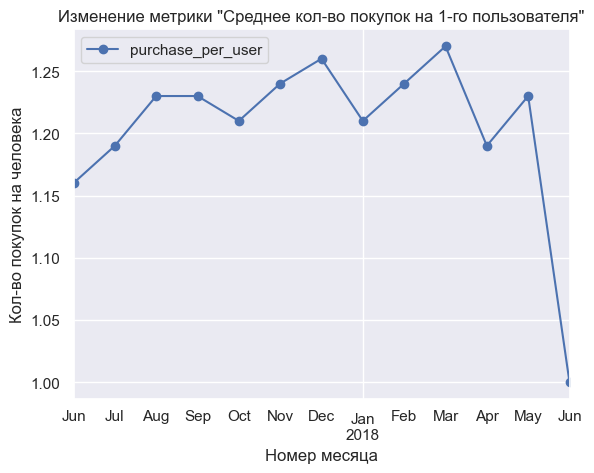

In [63]:
purchase_per_user.plot(x='order_month', y='purchase_per_user', style='o-')
plt.xlabel('Номер месяца')
plt.ylabel('Кол-во покупок на человека')
plt.title('Изменение метрики "Среднее кол-во покупок на 1-го пользователя"')

**Вывод**

В среднем на 1-го пользователя приходится **1.23 покупка**. На графике можно наблюдать, как изменяется этот показатель с течением времени. В целом он достаточно стабилен. В июне был только 1 заказ (возможно последние данные на момент выгрузки), так что это колебание не показательно

### 2.2.3. Средний чек

In [64]:
avg_check = orders_log.groupby('order_month').agg({'Revenue': 'sum', 'Uid': 'count'}).reset_index()
avg_check.columns = ['order_month', 'revenue', 'count_users']
avg_check['avg_check'] = round(avg_check['revenue'] / avg_check['count_users'], 2)
avg_check

,order_month,revenue,count_users,avg_check
0,2017-06-01,9557.49,2354,4.06
1,2017-07-01,12539.47,2363,5.31
2,2017-08-01,8758.78,1807,4.85
3,2017-09-01,18345.51,3387,5.42
4,2017-10-01,27987.70,5679,4.93
5,2017-11-01,27069.93,5659,4.78
6,2017-12-01,36388.60,6218,5.85
7,2018-01-01,19417.13,4721,4.11
8,2018-02-01,25560.54,5281,4.84
9,2018-03-01,28834.59,5326,5.41


Text(0.5, 1.0, 'Изменение среднего чека по месяцам')

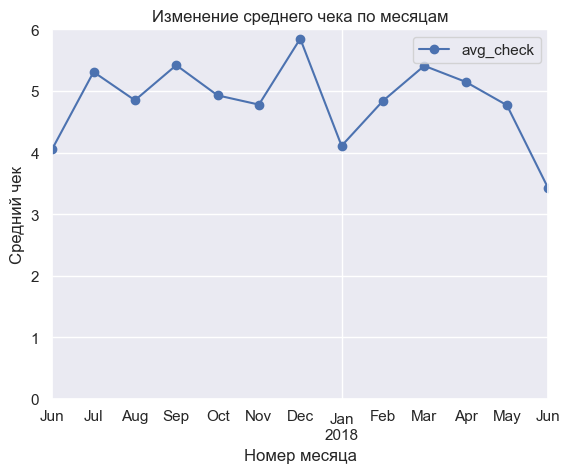

In [65]:
avg_check.plot(x='order_month', y='avg_check', style='o-', grid=True)
plt.xlabel('Номер месяца')
plt.ylabel('Средний чек')
plt.ylim(0, 6)
plt.title('Изменение среднего чека по месяцам')

In [66]:
orders_log['Revenue'].mean()

4.999646930477041

**Выводы**

Средний чек **близок к 5 у.е.**. В течение времени это значение находится в диапазоне от 4 до 6

### 2.2.4. Изменение LTV по когортам

In [67]:
cohort_sizes = orders_log.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [68]:
cohorts = orders_log.groupby(['first_order_month', 'order_month']).agg({'Revenue': 'sum'}).reset_index()
cohorts

,first_order_month,order_month,Revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [69]:
cohorts = cohorts.merge(cohort_sizes)

In [70]:
# По нашим данным маржинальность равняется 100%, поэтому работаем сразу с прибылью
cohorts['age'] = ((cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M'))
cohorts['age'] = cohorts['age'].round().astype('int')
cohorts['ltv'] = round(cohorts['Revenue'] / cohorts['n_buyers'], 2)
cohorts

,first_order_month,order_month,Revenue,n_buyers,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,0,4.72
1,2017-06-01,2017-07-01,981.82,2023,1,0.49
2,2017-06-01,2017-08-01,885.34,2023,2,0.44
3,2017-06-01,2017-09-01,1931.30,2023,3,0.95
4,2017-06-01,2017-10-01,2068.58,2023,4,1.02
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,3533,2,0.32
75,2018-04-01,2018-04-01,10600.69,2276,0,4.66
76,2018-04-01,2018-05-01,1209.92,2276,1,0.53
77,2018-05-01,2018-05-01,13925.76,2988,0,4.66


In [71]:
# Построим сводную таблицу для накопительного LTV 
ltv_pivot = cohorts.pivot_table(index='first_order_month', columns='age', values='ltv')
ltv_pivot.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5.0,5.93,7.0,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


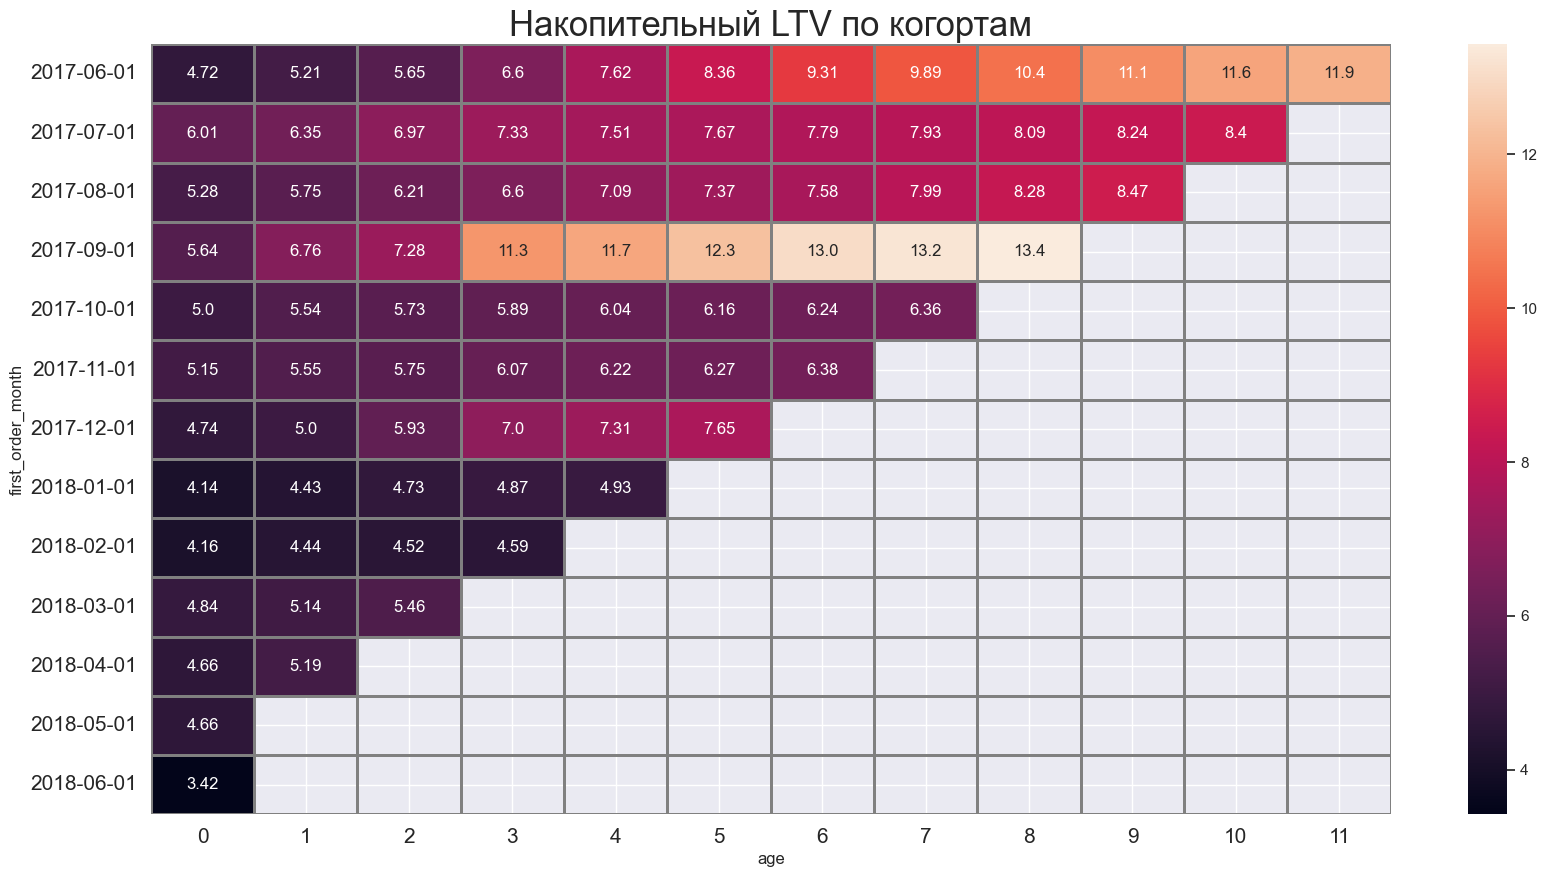

In [72]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(style='white')
sns.set(font_scale=1)
plt.tick_params(axis='both', which='major', labelsize= 15)
sns.heatmap(ltv_pivot.cumsum(axis=1), annot=True, fmt='.3', linewidths=1, linecolor='gray')
plt.title('Накопительный LTV по когортам', fontsize=25)
ax.set_yticklabels(ltv_pivot.index.date)
plt.show()

**Вывод**

Несмотря на то, что специфика продукта попадает под "одноразовую", практически для каждой когорты можно наблюдать последующее принесение прибыли. На графике в положительную сторону выделяются июньская и сентябрьская когорты. Возможно, для них были особые предложения, повлиявшие на активность. Однако преимущественно основная выручка приходится на месяц совершения сделки.

## 2.3. Метрики электронной коммерции

### 2.3.1. Общая сумма расходов на маркетинг по источникам

In [73]:
costs.head()

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [74]:
source_costs = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().sort_values('costs', ascending=False)
source_costs

,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


In [75]:
source_costs['costs'].sum()

329131.62

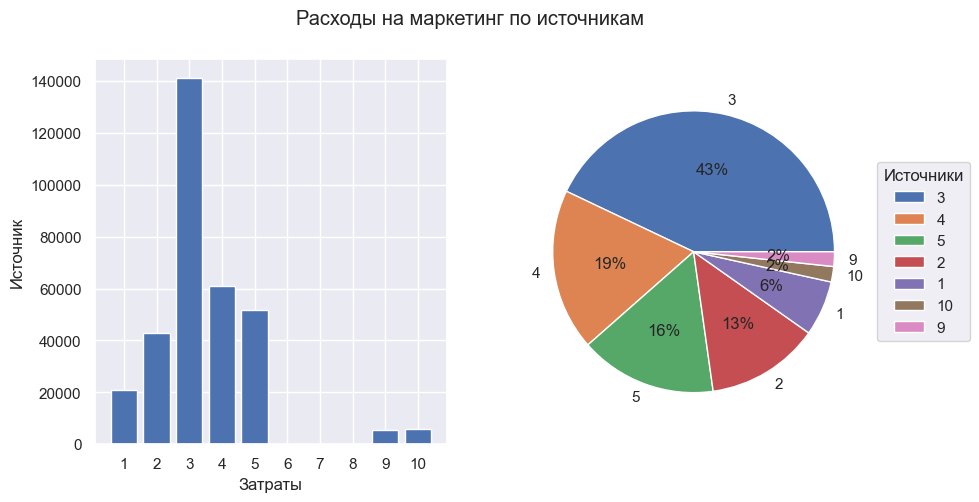

In [76]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(source_costs['source_id'], source_costs['costs'])
plt.suptitle('Расходы на маркетинг по источникам')
axs[0].set_ylabel('Источник')
axs[0].set_xlabel('Затраты')
axs[0].set_xticks(np.arange(1, 11, 1))

axs[1].pie(source_costs['costs'], labels=source_costs['source_id'], autopct='%1.0f%%')
axs[1].legend(source_costs['source_id'], title='Источники', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1));

**Вывод**

**Суммарно** затраты на маркетинг составляют **329132 у.е.**

Практически **половина** затрат на маркетинг идет на **источник № 3** (141321 у.е.). Источники № 2, 4 и 5 имеют схожие доли и забирают такой же объем инвестиций в маркетинг. Остальные 10% затрат идут на источники № 1, 9 и 10.

### 2.3.2. CAC на одного покупателя для всего проекта и для каждого источника трафика

**Сначала рассчитаем показатель в совокупности для всего трафика**

In [77]:
costs['date'] = costs['date'].dt.date
costs['costs_month'] = costs['date'].astype('datetime64[M]')

In [78]:
costs.head()

,source_id,date,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [79]:
costs_per_month = costs.groupby('costs_month').agg({'costs': 'sum'}).reset_index()
costs_per_month.head()

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [80]:
cohorts = cohorts.merge(costs_per_month, left_on='first_order_month', right_on='costs_month')
cohorts.drop(columns=['costs_month'], inplace=True)

In [81]:
cohorts.head()

,first_order_month,order_month,Revenue,n_buyers,age,ltv,costs
0,2017-06-01,2017-06-01,9557.49,2023,0,4.72,18015.0
1,2017-06-01,2017-07-01,981.82,2023,1,0.49,18015.0
2,2017-06-01,2017-08-01,885.34,2023,2,0.44,18015.0
3,2017-06-01,2017-09-01,1931.30,2023,3,0.95,18015.0
4,2017-06-01,2017-10-01,2068.58,2023,4,1.02,18015.0


In [82]:
cohorts['cac'] = round(cohorts['costs'] / cohorts['n_buyers'], 2)
cohorts['romi'] = round(cohorts['ltv'] / cohorts['cac'], 2)

cohorts.head()

,first_order_month,order_month,Revenue,n_buyers,age,ltv,costs,cac,romi
0,2017-06-01,2017-06-01,9557.49,2023,0,4.72,18015.0,8.91,0.53
1,2017-06-01,2017-07-01,981.82,2023,1,0.49,18015.0,8.91,0.05
2,2017-06-01,2017-08-01,885.34,2023,2,0.44,18015.0,8.91,0.05
3,2017-06-01,2017-09-01,1931.30,2023,3,0.95,18015.0,8.91,0.11
4,2017-06-01,2017-10-01,2068.58,2023,4,1.02,18015.0,8.91,0.11


In [83]:
# Рассчитаем показатель ROMI для всех источников трафика
romi_pivot = cohorts.pivot_table(index='first_order_month', columns='age', values='romi')
romi_pivot.cumsum(axis=1)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.58,0.63,0.74,0.85,0.93,1.04,1.11,1.17,1.24,1.3,1.33
2017-07-01,0.63,0.67,0.74,0.78,0.80,0.82,0.83,0.84,0.86,0.88,0.9,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.69,0.71,0.75,0.78,0.80,NaN,NaN
2017-09-01,0.60,0.72,0.78,1.20,1.24,1.31,1.38,1.41,1.43,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.73,0.74,0.75,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.59,0.61,0.64,0.66,0.67,0.68,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.88,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


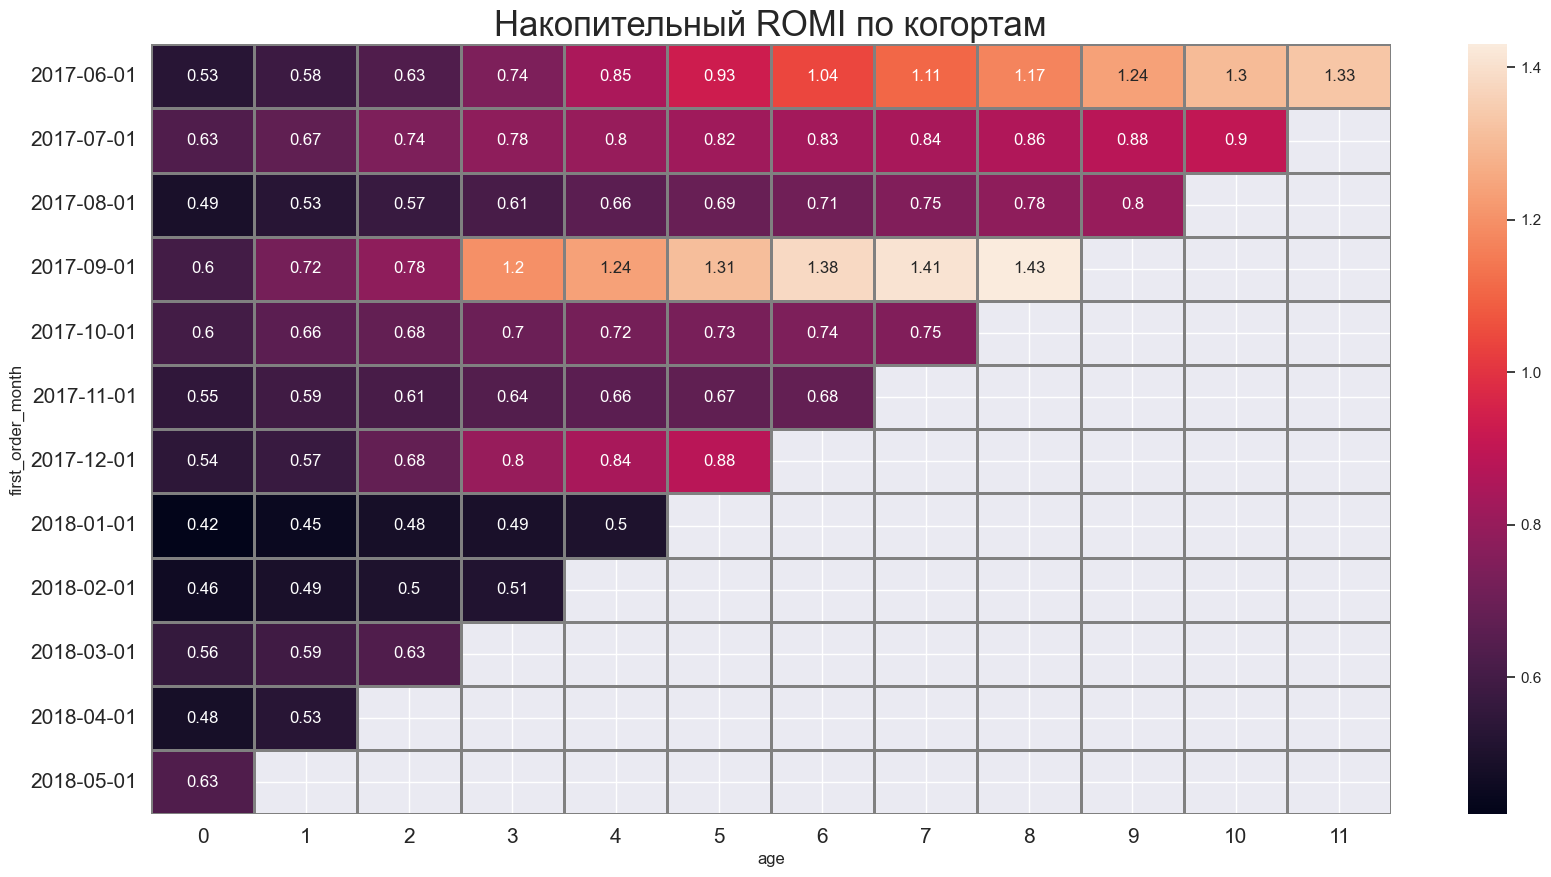

In [84]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(style='white')
sns.set(font_scale=1)
plt.tick_params(axis='both', which='major', labelsize= 15)
sns.heatmap(romi_pivot.cumsum(axis=1), annot=True, fmt='.3', linewidths=1, linecolor='gray')
plt.title('Накопительный ROMI по когортам', fontsize=25)
ax.set_yticklabels(romi_pivot.index.date)
plt.show()

In [111]:
all_source_cac = cohorts.groupby(['first_order_month', 'costs', 'n_buyers']).agg({'cac': 'max'}).reset_index()
all_source_cac

,first_order_month,costs,n_buyers,cac
0,2017-06-01,18015.00,2023,8.91
1,2017-07-01,18240.59,1923,9.49
2,2017-08-01,14790.54,1370,10.80
3,2017-09-01,24368.91,2581,9.44
4,2017-10-01,36322.88,4340,8.37
5,2017-11-01,37907.88,4081,9.29
6,2017-12-01,38315.35,4383,8.74
7,2018-01-01,33518.52,3373,9.94
8,2018-02-01,32723.03,3651,8.96
9,2018-03-01,30415.27,3533,8.61


Text(0, 0.5, 'Стоимость привлечения')

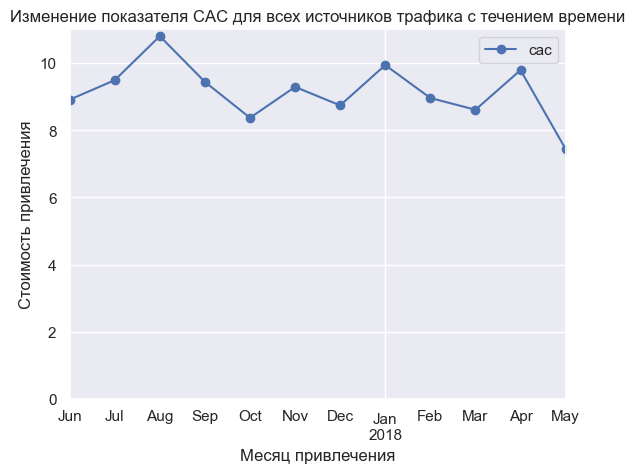

In [86]:
all_source_cac.plot(y='cac', x='first_order_month', style='o-')
plt.ylim(0, 11)
plt.title('Изменение показателя CAC для всех источников трафика с течением времени')
plt.xlabel('Месяц привлечения')
plt.ylabel('Стоимость привлечения')

**Далее рассмотрим показатель CAC в разрезе различных источников трафика**

In [87]:
visits_log.head()

,Device,End_Ts,Source Id,Start_Ts,Uid,date,day,weekday,week,month,year,session_duration,first_visit,first_visit_date,visit_month,first_visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,2,51,12,2017,18.0,2017-12-20 17:20:00,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,0,8,2,2018,28.0,2018-02-19 16:53:00,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,5,26,7,2017,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,6,20,5,2018,24.0,2018-03-09 20:05:00,2018-03-09,2018-05-01,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,2,52,12,2017,0.0,2017-12-27 14:06:00,2017-12-27,2017-12-01,2017-12-01,0


In [88]:
orders_log.head()

,Buy_Ts,Revenue,Uid,purchase_date,first_purchase_date,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [89]:
# Отберем те источники, с которых пользователь первый раз зашел на сайт
visits_by_source = visits_log[visits_log['Start_Ts'] == visits_log['first_visit']][['Uid', 'Source Id']]
visits_by_source.head()

,Uid,Source Id
0,16879256277535980062,4
1,104060357244891740,2
2,7459035603376831527,5
4,9969694820036681168,3
5,16007536194108375387,5


In [90]:
# Закрепим данные источники за конкретными пользователями и заказами
orders_log = orders_log.merge(visits_by_source, on='Uid')

In [91]:
orders_log.head()

,Buy_Ts,Revenue,Uid,purchase_date,first_purchase_date,order_month,first_order_month,Source Id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,3


In [119]:
# Определим затарты на маркетинг по каждому источнику и каждому месяцу.
costs_per_source_and_month = costs.groupby(['costs_month', 'source_id']).agg({'costs': 'sum'}).reset_index()

# Названия столбцов изменим для удобного дальнейшео объединения
costs_per_source_and_month.columns = ['first_order_month', 'Source Id', 'costs']
costs_per_source_and_month.head()

,first_order_month,Source Id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [120]:
cac_per_source = orders_log.groupby(['order_month', 'Source Id']).agg({'Uid': 'nunique'}).reset_index()
cac_per_source.columns = ['order_month', 'Source Id', 'count_users']
#cac_per_source['cac'] = round(cac_per_source['revenue'] / cac_per_source['count_users'], 2)
cac_per_source.head()

,order_month,Source Id,count_users
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [121]:
cac_per_source = cac_per_source.merge(costs_per_source_and_month, 
                                      left_on=['order_month', 'Source Id'], 
                                      right_on=['first_order_month', 'Source Id'])
cac_per_source.drop(columns=['first_order_month'], inplace=True)

In [130]:
cac_per_source['cac'] = round(cac_per_source['costs'] / cac_per_source['count_users'], 2)
cac_per_source.head()

,order_month,Source Id,count_users,costs,cac
0,2017-06-01,1,190,1125.61,5.92
1,2017-06-01,2,235,2427.38,10.33
2,2017-06-01,3,638,7731.65,12.12
3,2017-06-01,4,413,3514.80,8.51
4,2017-06-01,5,384,2616.12,6.81


In [139]:
# Рассчитаем средний показатель CAC по различным источникам для всех пользователей и за все время
cac_per_source_mean = cac_per_source.groupby('Source Id').agg({'count_users': 'sum', 'costs': 'sum'}).reset_index()
cac_per_source_mean['mean_cac'] = round(cac_per_source_mean['costs'] / cac_per_source_mean['count_users'], 2)
cac_per_source_mean

,Source Id,count_users,costs,mean_cac
0,1,3405,20833.27,6.12
1,2,4246,42806.04,10.08
2,3,11590,141321.63,12.19
3,4,11363,61073.60,5.37
4,5,7618,51757.10,6.79
5,9,1383,5517.49,3.99
6,10,1412,5822.49,4.12


In [136]:
cac_per_source_pivot = cac_per_source.pivot_table(index='Source Id', columns='order_month', values='cac')
cac_per_source_pivot

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
Source Id,,,,,,,,,,,,
1,5.92,6.10,7.44,5.89,6.16,6.38,6.03,7.46,6.68,5.39,5.82,4.78
2,10.33,10.80,13.03,11.85,10.51,10.58,10.49,11.39,11.56,9.06,10.29,5.36
3,12.12,14.62,16.69,12.20,12.73,13.00,11.16,13.11,11.42,11.58,12.50,9.49
4,8.51,6.74,9.09,8.42,5.21,4.26,5.01,4.96,4.54,4.82,5.47,4.45
5,6.81,6.86,5.84,6.23,5.80,8.19,6.86,7.46,6.50,7.26,7.17,6.43
9,4.19,5.71,3.61,4.04,3.81,3.69,4.42,4.72,4.45,2.34,5.41,4.42
10,3.31,6.22,5.96,5.23,2.92,5.87,6.80,6.27,3.59,2.65,3.29,2.87


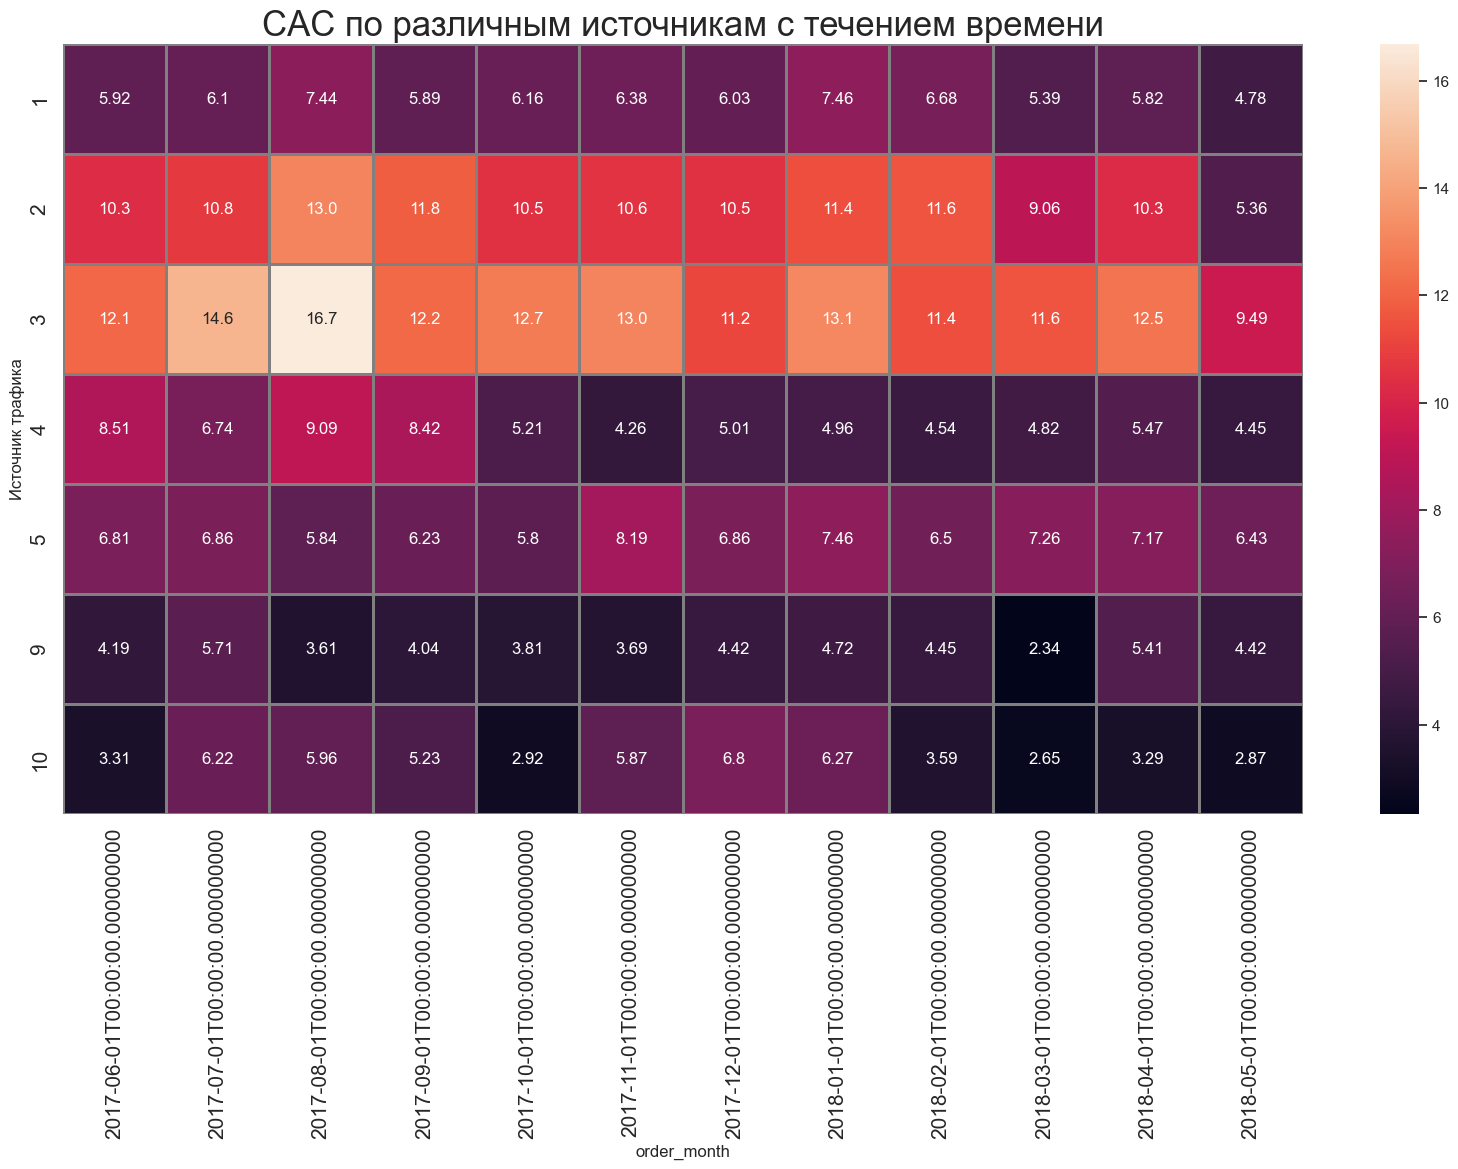

In [137]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(style='white')
sns.set(font_scale=1)
plt.tick_params(axis='both', which='major', labelsize= 15)
sns.heatmap(cac_per_source_pivot, annot=True, fmt='.3', linewidths=1, linecolor='gray')
plt.ylabel('Источник трафика')
plt.title('CAC по различным источникам с течением времени', fontsize=25)
plt.show()

**Вывод**

По графику общего накопительного ROMI можно сказать, что вложения в маркетинг окупились только для июньской (на 6-ой месяц) и сентябрьской (на 3-ий месяц) когорты 2017 года.

Если рассматривать CAC для совокупности трафика, то показатель с течением времени находится в диапазоне от 8 до 10.

В разрезе различных источников трафика по графику heatmap можно сделать вывод, что **источник №2 и №3 являются самыми дорогими** для привлечения пользователей (10 и 12 у.е. соотетственно). Их средняя стоимость привлечение клиента почти в 2 раза дороже остальных источников. **Средний сегмент - источники № 1, 4 и 5**, которые в среднем имеют показатель около 6 у.е. **Самые дешевые** источники привлечения - это **источник № 9 и 10**, где в среднем на привлечение 1-го покупателя уходит 4 у.е.

### 2.3.3. ROMI по когортам в разрезе источников

In [95]:
orders_log.head()

,Buy_Ts,Revenue,Uid,purchase_date,first_purchase_date,order_month,first_order_month,Source Id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,3


In [ ]:
orders_log['cohort_lifetime'] = orders_log['order_month'] - orders_log['first_order_month']
orders_log['cohort_lifetime'] = (orders_log['cohort_lifetime'] / np.timedelta64(1, 'M'))
orders_log['cohort_lifetime'] = orders_log['cohort_lifetime'].round().astype('int')

In [97]:
orders_cohorts = orders_log.groupby(['first_order_month', 'cohort_lifetime', 'Source Id']).agg({'Uid': 'nunique', 'Revenue': 'sum'}).reset_index()
orders_cohorts

,first_order_month,cohort_lifetime,Source Id,Uid,Revenue
0,2017-06-01,0,1,190,1378.70
1,2017-06-01,0,2,235,1043.68
2,2017-06-01,0,3,638,2804.34
3,2017-06-01,0,4,413,1959.84
4,2017-06-01,0,5,384,1898.89
...,...,...,...,...,...
511,2018-05-01,0,4,804,3802.91
512,2018-05-01,0,5,497,2094.04
513,2018-05-01,0,9,60,223.05
514,2018-05-01,0,10,130,470.89


In [98]:
source_users_count = orders_cohorts[orders_cohorts['cohort_lifetime'] == 0][['first_order_month', 'Source Id', 'Uid']]
source_users_count.rename(columns={'Uid': 'cohort_users'}, inplace=True)
source_users_count

,first_order_month,Source Id,cohort_users
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
...,...,...,...
511,2018-05-01,4,804
512,2018-05-01,5,497
513,2018-05-01,9,60
514,2018-05-01,10,130


In [99]:
orders_cohorts = orders_cohorts.merge(source_users_count, on=['first_order_month', 'Source Id'])

In [100]:
orders_cohorts.head()

,first_order_month,cohort_lifetime,Source Id,Uid,Revenue,cohort_users
0,2017-06-01,0,1,190,1378.70,190
1,2017-06-01,1,1,16,414.98,190
2,2017-06-01,2,1,10,419.43,190
3,2017-06-01,3,1,9,714.24,190
4,2017-06-01,4,1,12,811.20,190


In [101]:
orders_cohorts['ltv'] = round(orders_cohorts['Revenue'] / orders_cohorts['cohort_users'], 2)

In [102]:
costs.head()

,source_id,date,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [112]:
# Затраты затарты на маркетинг по каждому источнику и каждому месяцу рассчитаны в разделе с CAC
costs_per_source_and_month.head()

,first_order_month,Source Id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [104]:
orders_cohorts = orders_cohorts.merge(costs_per_source_and_month, on=['first_order_month', 'Source Id'])

In [105]:
orders_cohorts.head()

,first_order_month,cohort_lifetime,Source Id,Uid,Revenue,cohort_users,ltv,costs
0,2017-06-01,0,1,190,1378.70,190,7.26,1125.61
1,2017-06-01,1,1,16,414.98,190,2.18,1125.61
2,2017-06-01,2,1,10,419.43,190,2.21,1125.61
3,2017-06-01,3,1,9,714.24,190,3.76,1125.61
4,2017-06-01,4,1,12,811.20,190,4.27,1125.61


In [106]:
orders_cohorts['cac'] = round(orders_cohorts['costs'] / orders_cohorts['cohort_users'], 2)
orders_cohorts['romi'] = round(orders_cohorts['ltv'] / orders_cohorts['cac'], 2)
orders_cohorts.head()

,first_order_month,cohort_lifetime,Source Id,Uid,Revenue,cohort_users,ltv,costs,cac,romi
0,2017-06-01,0,1,190,1378.70,190,7.26,1125.61,5.92,1.23
1,2017-06-01,1,1,16,414.98,190,2.18,1125.61,5.92,0.37
2,2017-06-01,2,1,10,419.43,190,2.21,1125.61,5.92,0.37
3,2017-06-01,3,1,9,714.24,190,3.76,1125.61,5.92,0.64
4,2017-06-01,4,1,12,811.20,190,4.27,1125.61,5.92,0.72


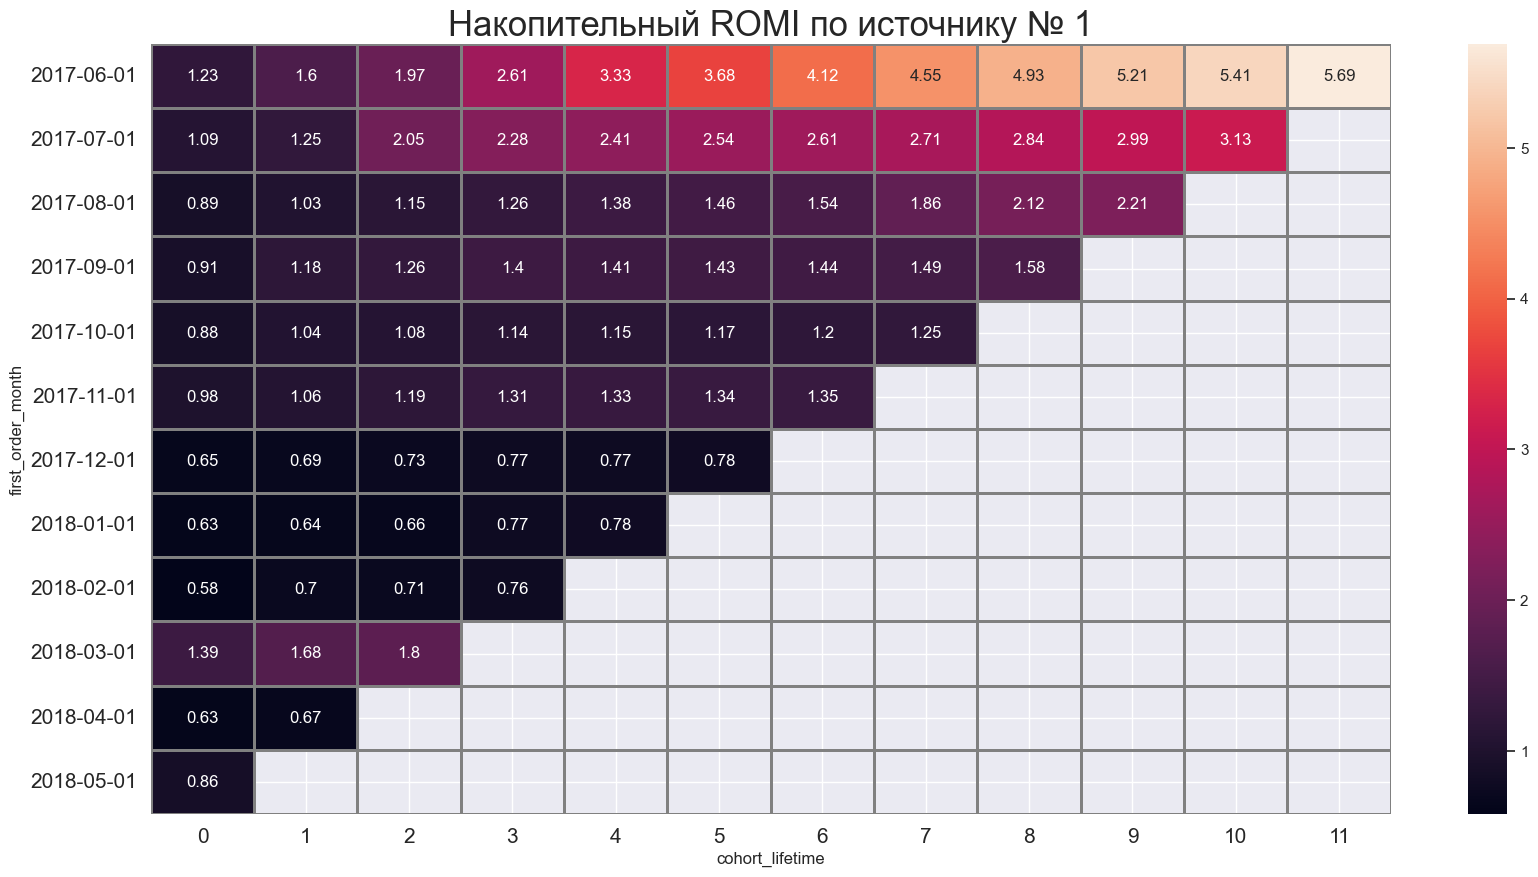

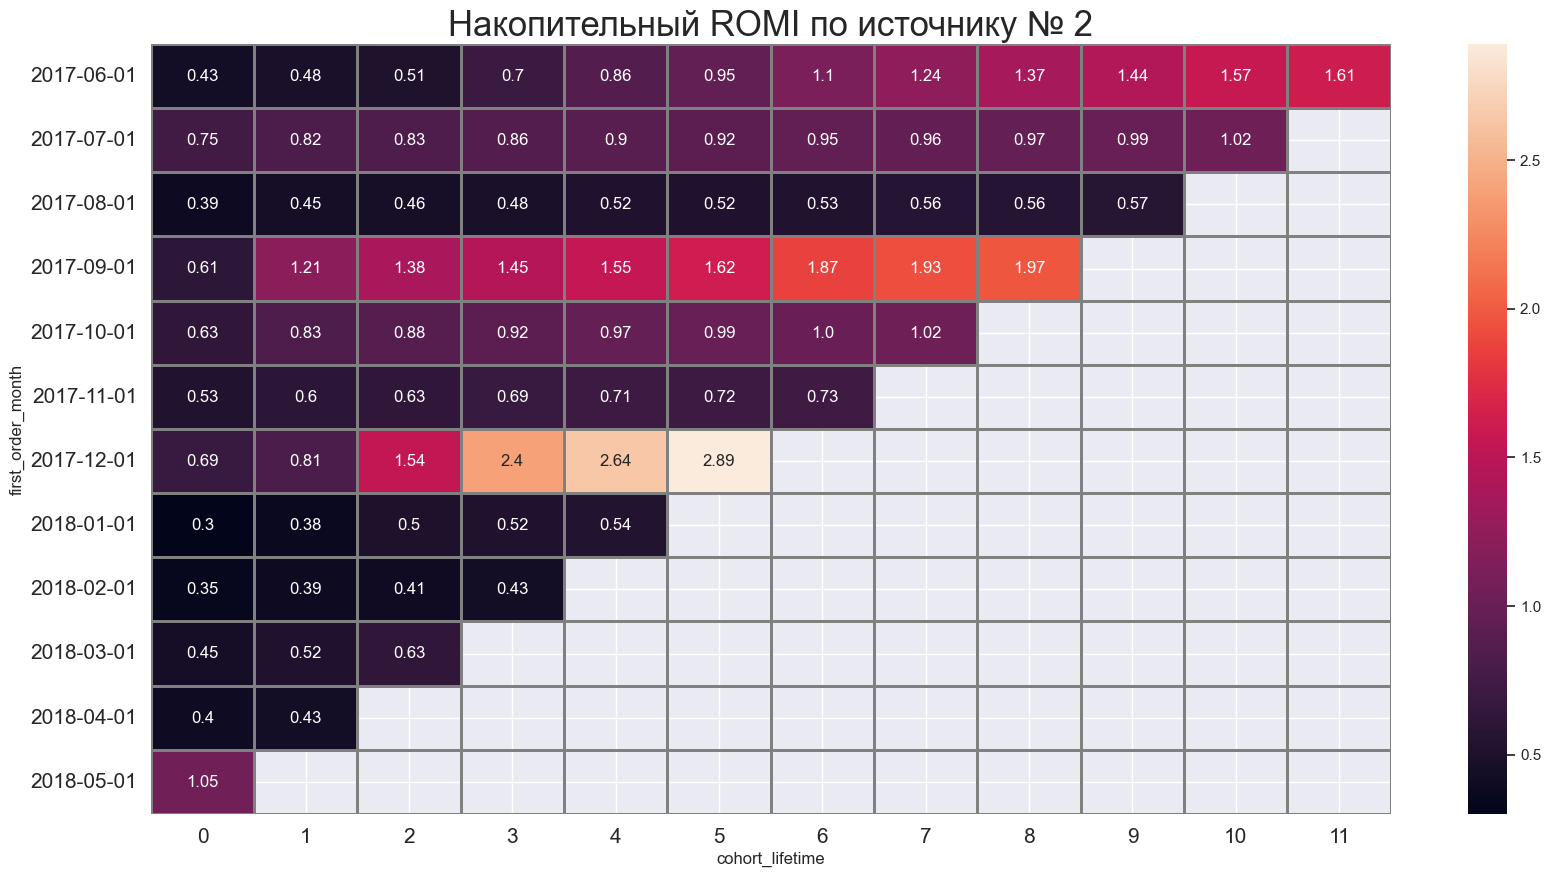

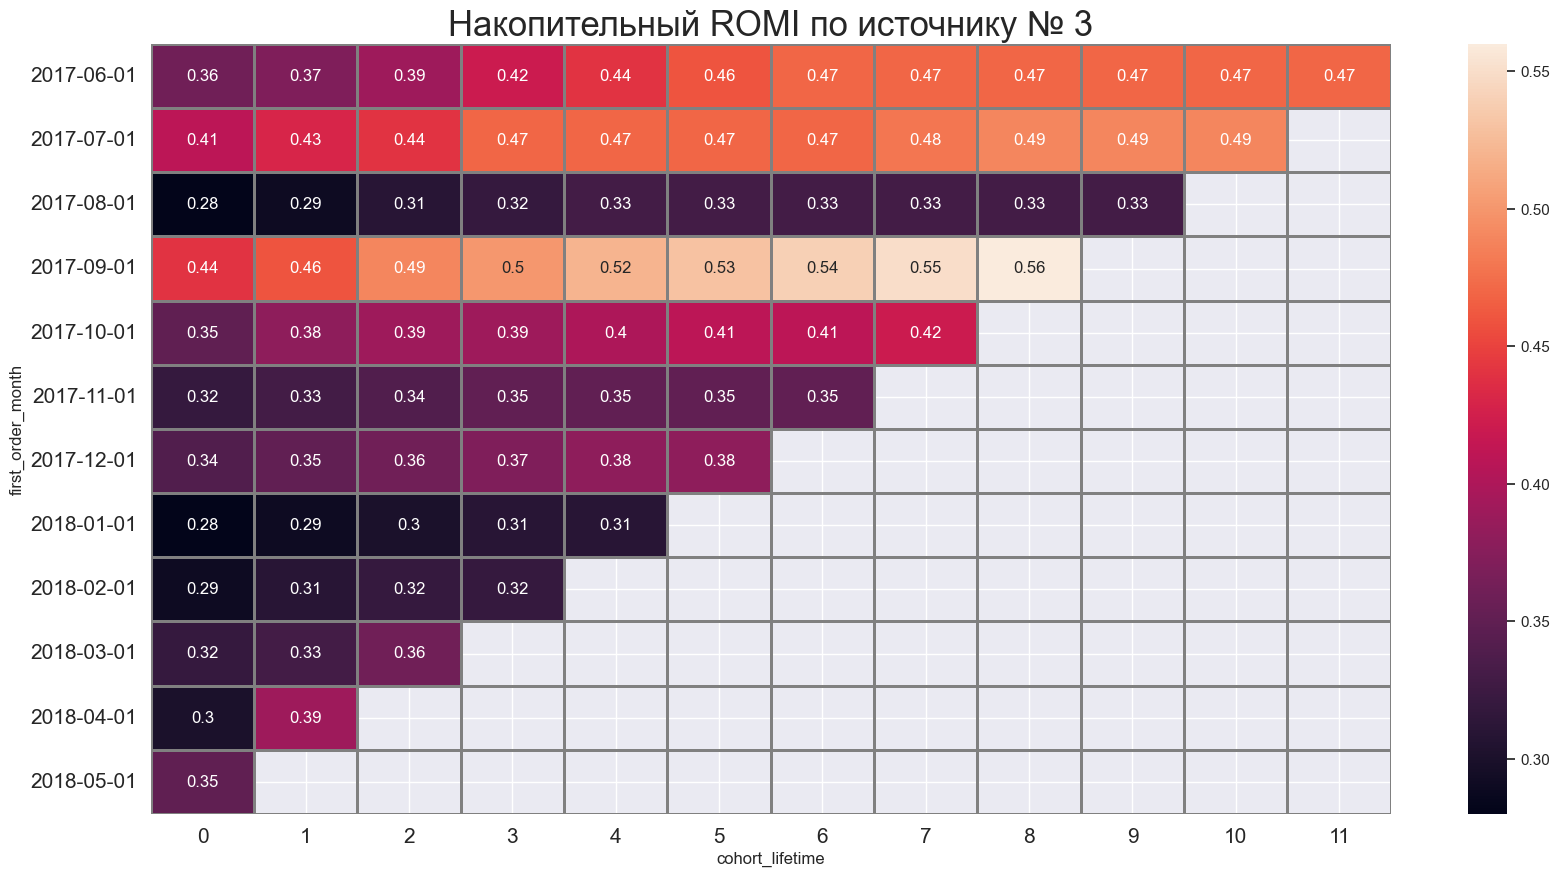

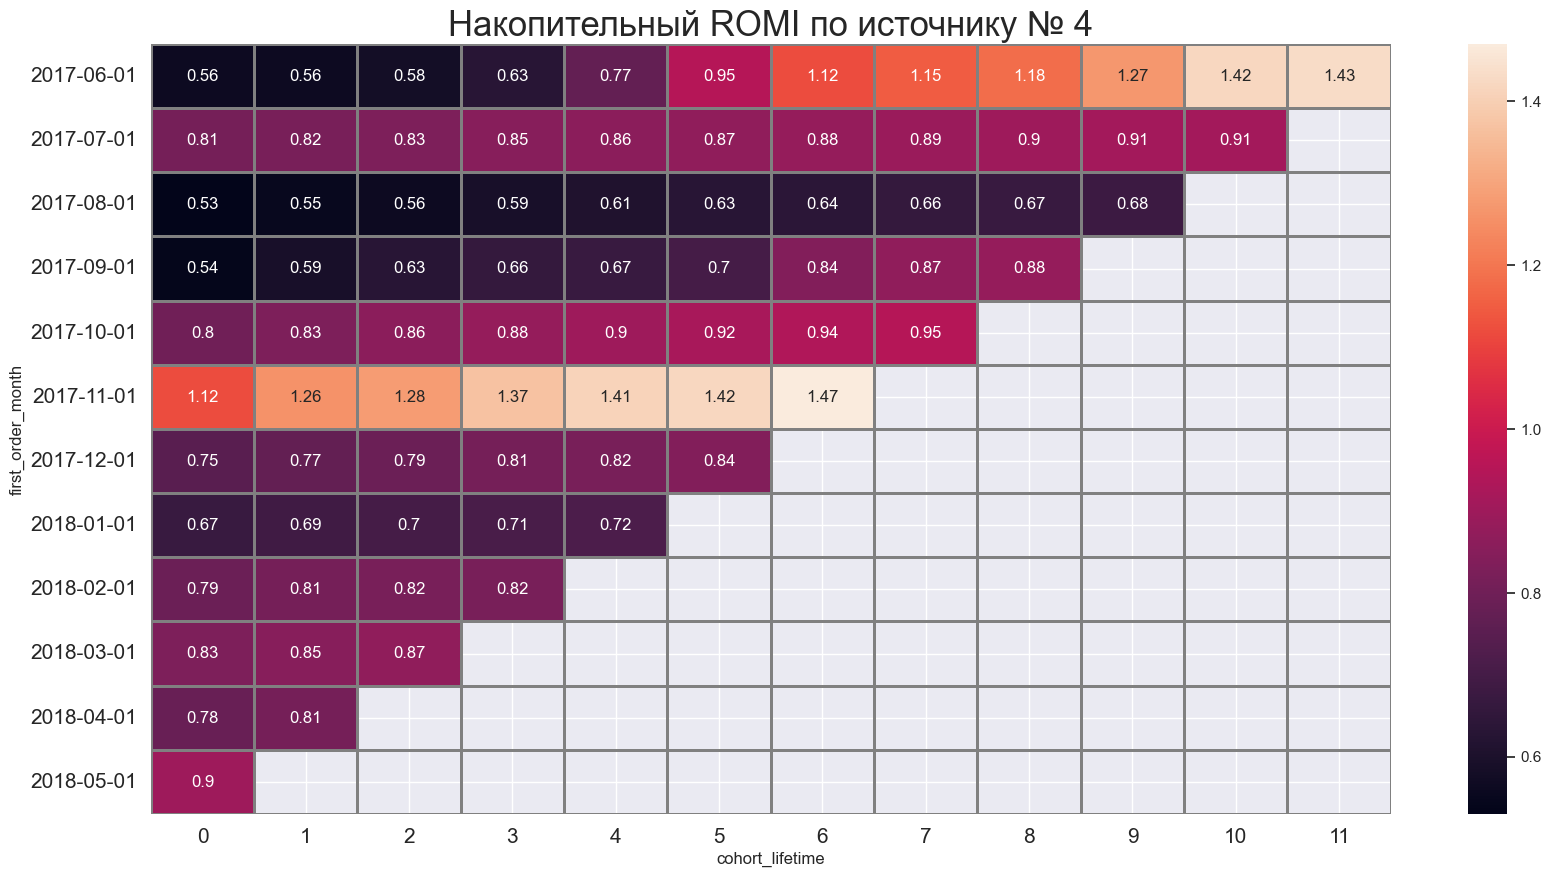

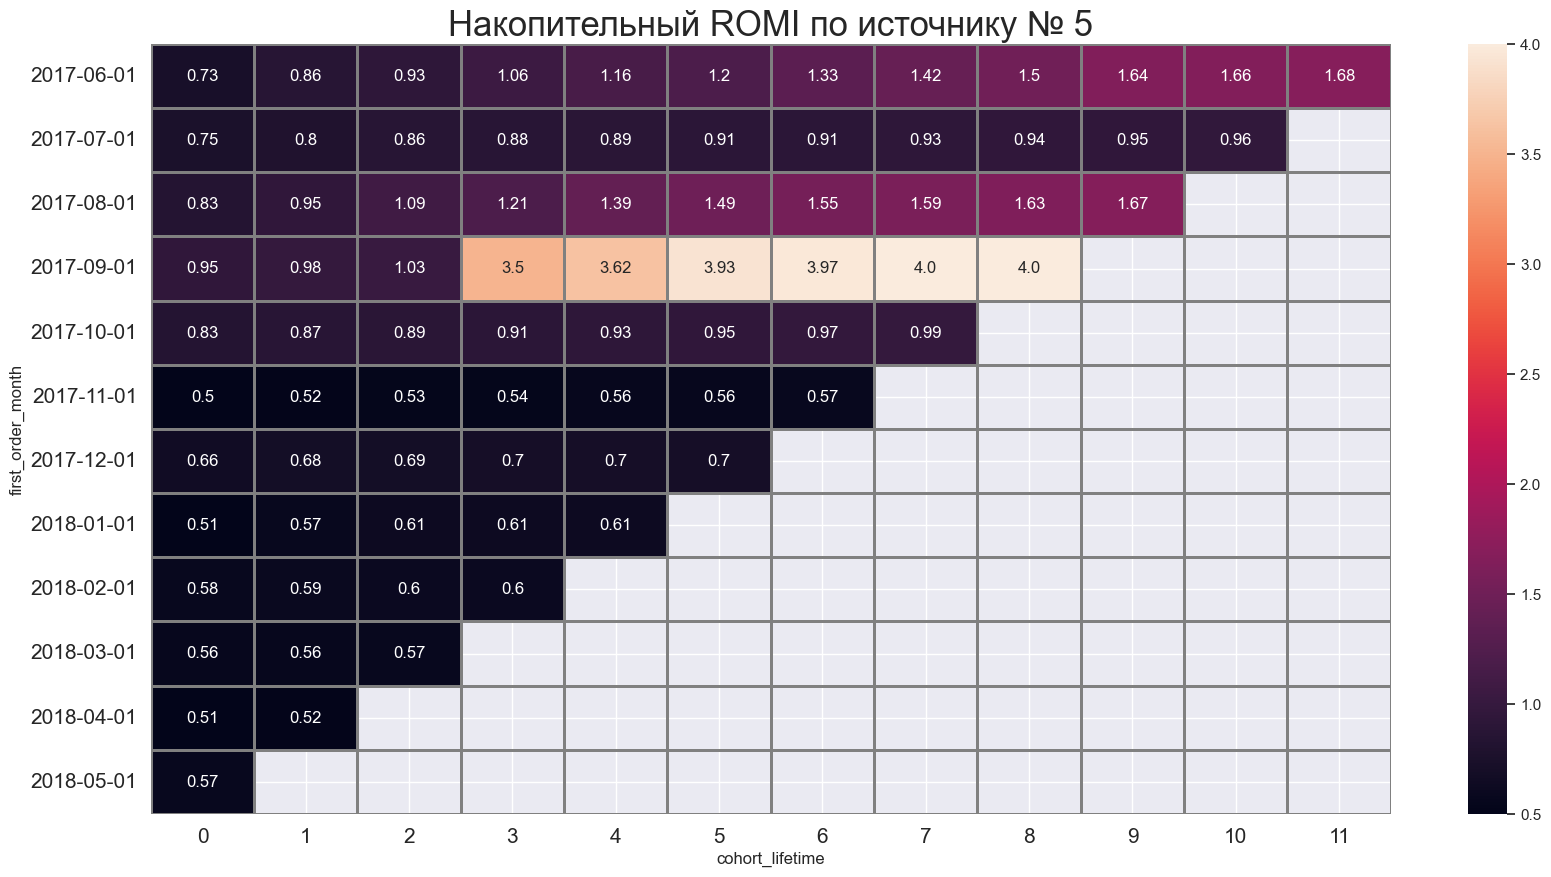

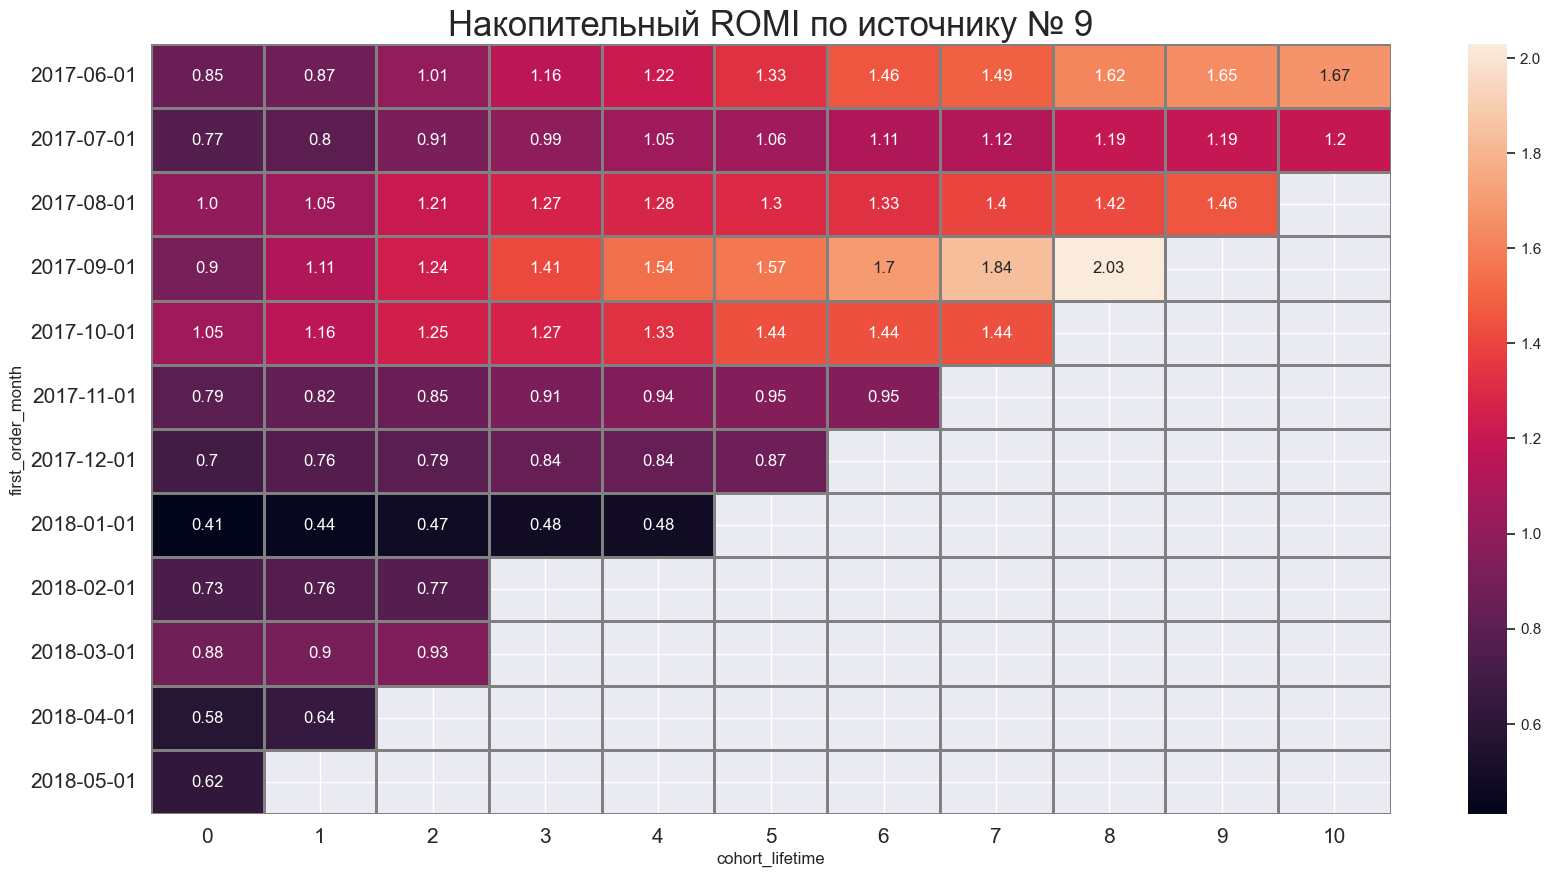

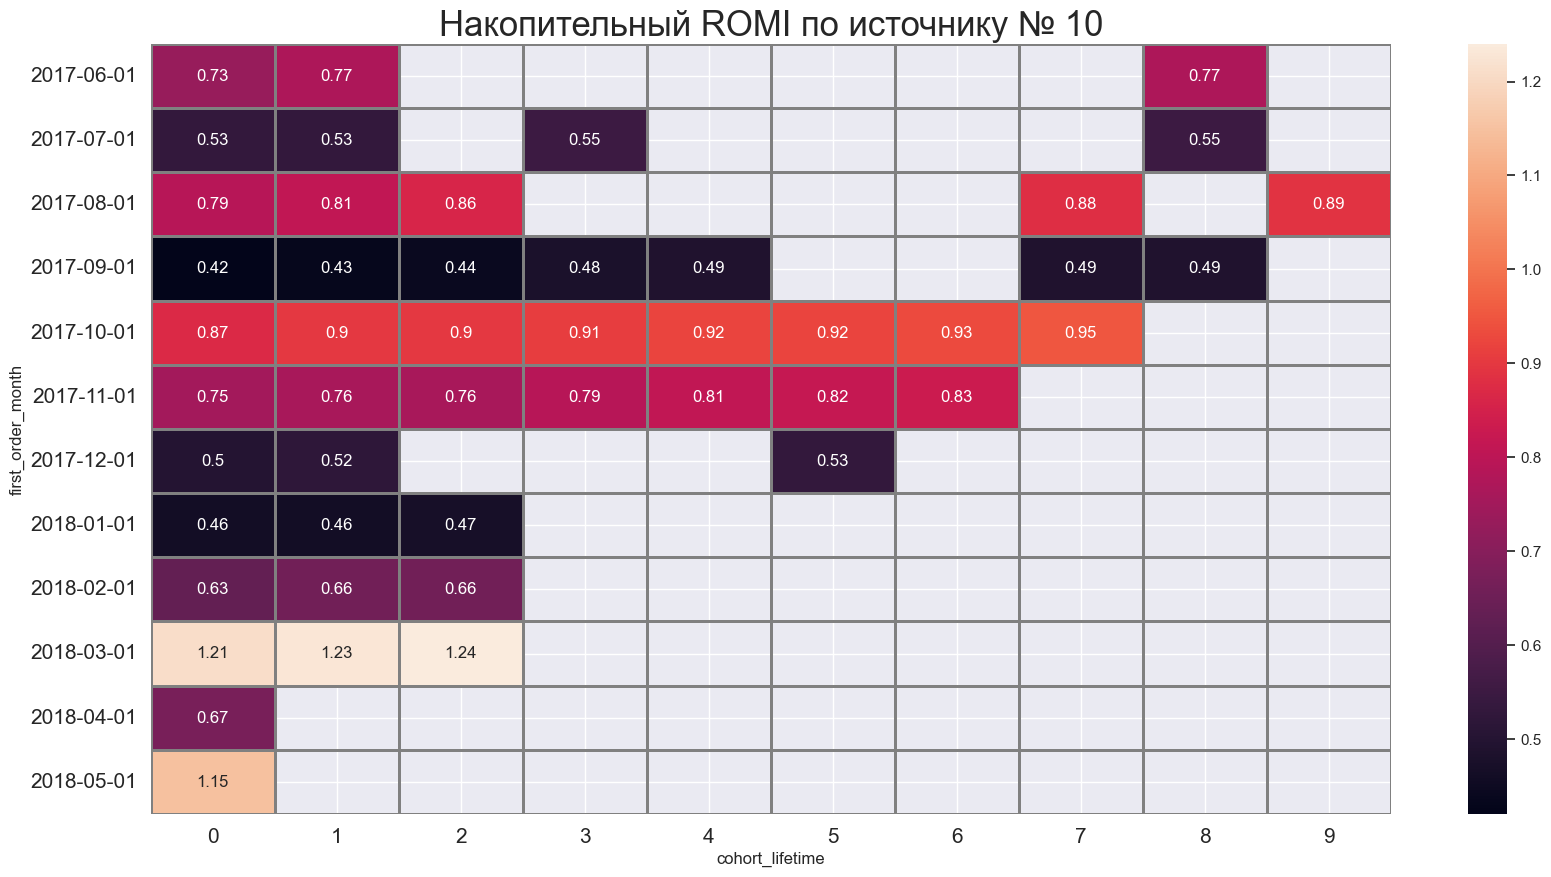

In [107]:
# Автоматизируем процесс построения графиков для каждого источника
for source, group_data in orders_cohorts.groupby('Source Id'):
    new_pivot = group_data.pivot_table(index='first_order_month', 
                                       columns='cohort_lifetime', 
                                       values='romi')
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.set(style='white')
    sns.set(font_scale=1)
    plt.tick_params(axis='both', which='major', labelsize= 15)
    sns.heatmap(new_pivot.cumsum(axis=1), annot=True, fmt='.3', linewidths=1, linecolor='gray')
    plt.title(f'Накопительный ROMI по источнику № {source}', fontsize=25)
    ax.set_yticklabels(romi_pivot.index.date)
    plt.show()

**Выводы**

Проанализировав все источники трафика можно сделать вывод, что самые **лучшие** показатели у **источника № 1**, где **окупаемость** маркетинговых затрат почти у каждой когорты наступает почти всегда **на 2-ой месяц**. Июньские затраты на привлечение клиентов за все время жизни когорты окупились более чем в 5 раз. Есть и не очень удачные когорты - декабрь, январь и февраль.

Также **хорошие показатели** и у источника **№ 9**, где часть когорт окупилась уже в 1-ый месяц. Однако зимние когорты тоже не очень успешны.

Есть **потенциал** у источников **№ 2, 4 и 5**, где многие когорты уже окупили себя или близки к этому.

Источник **№10** имеет **единичные случаи окупаемости**. По многим отсутствующим значениям на графике видно, что источник привлекает только одноразовых клиентов. Прибыль с когорты в дальнейшем не развивается. **Плохой вариант** дя инвестиций.

**Источник № 3 абсолютно бесперспективен**. Затраты не окупаются даже на половину.



<a name='stage_3'><a/>
# Шаг 3. Общие выводы и рекомендации

[Вернуться к оглавлению](#contents)

Наблюдается **просадка** активных пользователей с недельной периодичностью. С помощью разбивки по дням недели мы выяснили, что **в выходные дни** количество активных юзеров сильно падает. Необходимо обратить внимание на причины.

Изучив **колебания MAU**, можно объяснить изменение количества активных пользователей **сезонностью продукта**: видно, что с начала марта количество пользователей начинает постепенно снижаться, а за апрель и вовсе теряется до 5000 пользователей. Практически линейный график бурного роста начинается с августа и достигает пика в конце ноября.

В среднем пользователи проводят на сайте около **12 минут**, а за сутки на сайт заходят **987 пользователей**.

Видно, что **после первого месяца пользования уходят около 94% пользователей**. Это говорит о том, что специфика бизнеса рассчитана в основном на единоразовую сделку. Возможно, следует уделить внимание улучшению показателя.

Среднее время между первым посещением сайта и первой покупкой составляет **16 минут**. На 1-го пользователя приходится **1.23 покупка**. **Средний чек близок к 5 у.е.**. В 
течение времени это значение находится в диапазоне от 4 до 6

**Лучшими источниками** для привлечения поьзователей и последующей окупаемости являются **источники № 1** (CAC - 6.12 у.е.) и **источник № 9** (CAC - 3.99 у.е.). Часть когорт окупилась уже в 1-ый месяц, многие на 2-ой месяц.

**Есть потенциал у источников № 2, 4 и 5**, где многие когорты уже окупили себя или близки к этому.

**Источник №3** является самыми дорогим для привлечения пользователей (12 у.е.). По оценке ROMI можно заметить, что затраты не окупаются даже на половину. **Источник №10** привлекает только одноразовых клиентов и не окупается. Их дальнейшее использование **крайне нежелательно**.

## Рекомендации бизнесу
* Оптимизировать затраты на маркетинг. На данный момент 43% затрат идут на самый неэффективный и дорогой источник трафика - источник №3. Траты на перспективные источники № 1 и № 9 сотавляют менее 8%;
* Предпринять меры для увеличения количества пользователей в выходные дни. Провести акции, сделать спецпредложения;
* Проработать вопрос удержания клиентов. Для обоснования такого низкого показателя Retention rate необходимо более подробное изучение причин. Изучить конкурентов, улучшить условия.